# [순환신경망 실습: 다변량 시계열 예측 모델링]

### 1. 모듈 불러오기

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from sklearn.metrics import mean_absolute_error

import seaborn as sns 
import matplotlib.pyplot as plt

### 2. 데이터 불러오기: YAHOO에서 한화 주식 데이터 불러오기

In [2]:
hanhwa_stock = pd.read_csv('Data/regression_multivariate_hanhwa_stock.csv', engine='python')

In [3]:
hanhwa_stock.head()

,Date,High,Low,Open,Volume,Close
0,2010-01-04,44196.39844,42899.19922,42943.89844,497686,39034.73828
1,2010-01-05,44822.69922,43928.00000,44375.39844,469947,39153.75000
2,2010-01-06,46343.60156,44464.80078,44464.80078,636396,40145.45703
3,2010-01-07,46254.19922,44912.19922,45627.89844,423085,39986.80859
4,2010-01-08,45985.80078,44420.10156,45985.80078,502115,40145.45703


In [4]:
hanhwa_stock.tail()

,Date,High,Low,Open,Volume,Close
2214,2018-12-21,32800.0,32150.0,32750.0,246397,32400.0
2215,2018-12-24,32350.0,31450.0,32000.0,122303,31950.0
2216,2018-12-26,31600.0,31000.0,31350.0,132277,31200.0
2217,2018-12-27,31900.0,30950.0,31050.0,167357,31850.0
2218,2018-12-28,31750.0,31200.0,31500.0,139309,31350.0


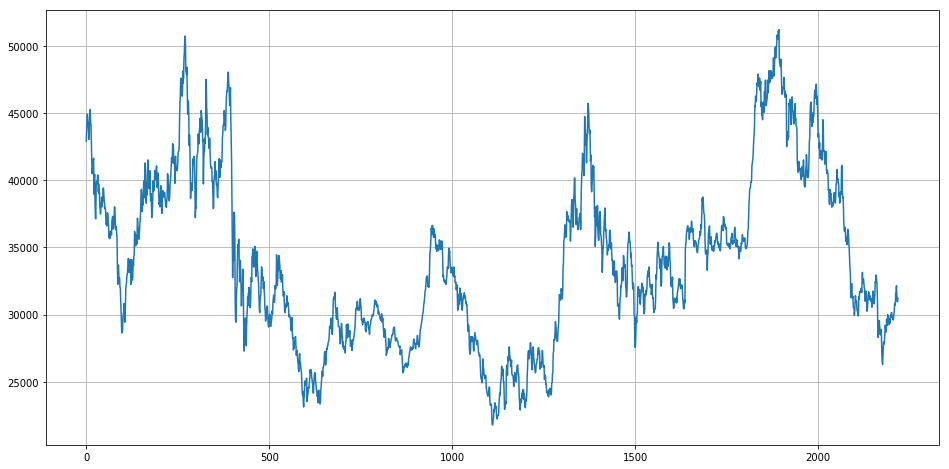

In [5]:
plt.figure(figsize=(16,8))
hanhwa_stock.Low.plot(grid=True)
plt.show()

In [6]:
print(hanhwa_stock.isna().sum())

Date      0
High      0
Low       0
Open      0
Volume    0
Close     0
dtype: int64


In [7]:
hanhwa_stock.shape

(2219, 6)

### 3. 데이터 전처리: sequence 길이에 맞게  RNN Input 데이터 만들기

In [8]:
hanhwa_stock = hanhwa_stock.set_index('Date')

In [9]:
hanhwa_stock.head()

,High,Low,Open,Volume,Close
Date,,,,,
2010-01-04,44196.39844,42899.19922,42943.89844,497686,39034.73828
2010-01-05,44822.69922,43928.00000,44375.39844,469947,39153.75000
2010-01-06,46343.60156,44464.80078,44464.80078,636396,40145.45703
2010-01-07,46254.19922,44912.19922,45627.89844,423085,39986.80859
2010-01-08,45985.80078,44420.10156,45985.80078,502115,40145.45703


In [10]:
data = hanhwa_stock[::-1]  # reverse order

In [11]:
data.head()

,High,Low,Open,Volume,Close
Date,,,,,
2018-12-28,31750.0,31200.0,31500.0,139309,31350.0
2018-12-27,31900.0,30950.0,31050.0,167357,31850.0
2018-12-26,31600.0,31000.0,31350.0,132277,31200.0
2018-12-24,32350.0,31450.0,32000.0,122303,31950.0
2018-12-21,32800.0,32150.0,32750.0,246397,32400.0


In [12]:
seq_length = 7 
train_size = int(len(data) * 0.7)

In [13]:
train_set = data[0:train_size]
test_set = data[train_size - seq_length:]

In [14]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [15]:
# scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

In [16]:
train_set.head()

,High,Low,Open,Volume,Close
Date,,,,,
2018-12-28,0.310347,0.320072,0.314396,0.058500,0.350883
2018-12-27,0.315238,0.311573,0.299419,0.070278,0.367201
2018-12-26,0.305456,0.313273,0.309404,0.055547,0.345987
2018-12-24,0.329912,0.328572,0.331037,0.051359,0.370465
2018-12-21,0.344585,0.352369,0.355998,0.103470,0.385152


In [17]:
train_set.head()

,High,Low,Open,Volume,Close
Date,,,,,
2018-12-28,0.310347,0.320072,0.314396,0.058500,0.350883
2018-12-27,0.315238,0.311573,0.299419,0.070278,0.367201
2018-12-26,0.305456,0.313273,0.309404,0.055547,0.345987
2018-12-24,0.329912,0.328572,0.331037,0.051359,0.370465
2018-12-21,0.344585,0.352369,0.355998,0.103470,0.385152


In [18]:
len(train_set)

1553

In [19]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series.iloc[i:i + seq_length, :]
        _y = time_series.iloc[i + seq_length, [-1]]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.stack(dataX), np.stack(dataY)

In [20]:
# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)


                High       Low      Open    Volume     Close
Date                                                        
2018-12-28  0.310347  0.320072  0.314396  0.058500  0.350883
2018-12-27  0.315238  0.311573  0.299419  0.070278  0.367201
2018-12-26  0.305456  0.313273  0.309404  0.055547  0.345987
2018-12-24  0.329912  0.328572  0.331037  0.051359  0.370465
2018-12-21  0.344585  0.352369  0.355998  0.103470  0.385152
2018-12-20  0.346216  0.335371  0.339357  0.142646  0.399838
2018-12-19  0.333172  0.333671  0.324381  0.109047  0.383520 -> Close    0.359042
Name: 2018-12-18, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-12-27  0.315238  0.311573  0.299419  0.070278  0.367201
2018-12-26  0.305456  0.313273  0.309404  0.055547  0.345987
2018-12-24  0.329912  0.328572  0.331037  0.051359  0.370465
2018-12-21  0.344585  0.352369  0.355998  0.103470  0.385152
2018-12-20  0.346216  0.335371 

2018-11-30  0.269587  0.272478  0.274458  0.068376  0.306823 -> Close    0.316614
Name: 2018-11-29, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-12-07  0.272848  0.272478  0.282778  0.056597  0.316614
2018-12-06  0.269587  0.275877  0.281114  0.086866  0.318246
2018-12-05  0.267957  0.274177  0.262809  0.062625  0.319878
2018-12-04  0.281000  0.284376  0.284442  0.069857  0.314982
2018-12-03  0.284261  0.284376  0.272794  0.077981  0.334564
2018-11-30  0.269587  0.272478  0.274458  0.068376  0.306823
2018-11-29  0.279370  0.277577  0.276122  0.076194  0.316614 -> Close    0.306823
Name: 2018-11-28, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-12-06  0.269587  0.275877  0.281114  0.086866  0.318246
2018-12-05  0.267957  0.274177  0.262809  0.062625  0.319878
2018-12-04  0.281000  0.284376  0.2844

2018-11-12  0.235349  0.240181  0.229528  0.035943  0.287241 -> Close    0.283977
Name: 2018-11-09, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-11-19  0.272848  0.279277  0.264473  0.063750  0.313350
2018-11-16  0.259805  0.255479  0.252825  0.068192  0.310087
2018-11-15  0.269587  0.252080  0.277786  0.110291  0.295400
2018-11-14  0.269587  0.267378  0.254489  0.083564  0.323141
2018-11-13  0.250023  0.235082  0.234520  0.073915  0.298664
2018-11-12  0.235349  0.240181  0.229528  0.035943  0.287241
2018-11-09  0.240241  0.250380  0.246168  0.039830  0.283977 -> Close    0.290504
Name: 2018-11-08, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-11-16  0.259805  0.255479  0.252825  0.068192  0.310087
2018-11-15  0.269587  0.252080  0.277786  0.110291  0.295400
2018-11-14  0.269587  0.267378  0.2544

2018-10-23  0.243501  0.228282  0.254489  0.093770  0.274186 -> Close    0.300295
Name: 2018-10-22, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-10-30  0.178286  0.153490  0.149651  0.122468  0.220335
2018-10-29  0.192959  0.161989  0.169620  0.115611  0.194225
2018-10-26  0.225567  0.184087  0.231192  0.154155  0.223599
2018-10-25  0.225567  0.224883  0.222871  0.091263  0.272554
2018-10-24  0.236980  0.241881  0.236184  0.065359  0.290504
2018-10-23  0.243501  0.228282  0.254489  0.093770  0.274186
2018-10-22  0.246762  0.235082  0.231192  0.083098  0.300295 -> Close    0.282345
Name: 2018-10-19, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-10-29  0.192959  0.161989  0.169620  0.115611  0.194225
2018-10-26  0.225567  0.184087  0.231192  0.154155  0.223599
2018-10-25  0.225567  0.224883  0.2228

2018-10-01  0.354367  0.360868  0.357662  0.078358  0.404734 -> Close    0.398206
Name: 2018-09-28, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-10-10  0.334803  0.318373  0.332701  0.108788  0.350883
2018-10-08  0.359259  0.352369  0.360990  0.095498  0.385152
2018-10-05  0.364150  0.367667  0.364319  0.081293  0.411261
2018-10-04  0.372302  0.372767  0.379295  0.123524  0.417789
2018-10-02  0.382084  0.379566  0.367647  0.159175  0.419420
2018-10-01  0.354367  0.360868  0.357662  0.078358  0.404734
2018-09-28  0.355998  0.362568  0.364319  0.084100  0.398206 -> Close    0.412893
Name: 2018-09-27, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-10-08  0.359259  0.352369  0.360990  0.095498  0.385152
2018-10-05  0.364150  0.367667  0.364319  0.081293  0.411261
2018-10-04  0.372302  0.372767  0.3792

2018-09-06  0.308717  0.321772  0.317724  0.061682  0.352515 -> Close    0.355778
Name: 2018-09-05, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-09-13  0.300565  0.311573  0.306076  0.097114  0.337828
2018-09-12  0.298934  0.297975  0.307740  0.099653  0.352515
2018-09-11  0.315238  0.318373  0.321052  0.062751  0.345987
2018-09-10  0.308717  0.316673  0.302747  0.064914  0.362306
2018-09-07  0.307086  0.313273  0.317724  0.077095  0.350883
2018-09-06  0.308717  0.321772  0.317724  0.061682  0.352515
2018-09-05  0.313608  0.326872  0.317724  0.073696  0.355778 -> Close    0.359042
Name: 2018-09-04, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-09-12  0.298934  0.297975  0.307740  0.099653  0.352515
2018-09-11  0.315238  0.318373  0.321052  0.062751  0.345987
2018-09-10  0.308717  0.316673  0.3027

2018-08-17  0.307086  0.318373  0.319388  0.088782  0.352515 -> Close    0.354146
Name: 2018-08-16, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-08-24  0.279370  0.289476  0.282778  0.083605  0.331301
2018-08-23  0.305456  0.287776  0.317724  0.261739  0.323141
2018-08-22  0.316869  0.328572  0.327709  0.080811  0.354146
2018-08-21  0.328281  0.338770  0.337693  0.064270  0.372097
2018-08-20  0.329912  0.323472  0.319388  0.112881  0.378624
2018-08-17  0.307086  0.318373  0.319388  0.088782  0.352515
2018-08-16  0.333172  0.313273  0.337693  0.194921  0.354146 -> Close    0.398206
Name: 2018-08-14, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-08-23  0.305456  0.287776  0.317724  0.261739  0.323141
2018-08-22  0.316869  0.328572  0.327709  0.080811  0.354146
2018-08-21  0.328281  0.338770  0.3376

2018-07-27  0.334803  0.338770  0.332701  0.069677  0.378624 -> Close    0.370465
Name: 2018-07-26, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-08-03  0.386975  0.360868  0.352670  0.430267  0.437371
2018-08-02  0.339694  0.335371  0.334365  0.145381  0.368833
2018-08-01  0.334803  0.345570  0.347678  0.048140  0.380256
2018-07-31  0.347846  0.345570  0.341021  0.099574  0.376992
2018-07-30  0.326651  0.337071  0.329373  0.067016  0.376992
2018-07-27  0.334803  0.338770  0.332701  0.069677  0.378624
2018-07-26  0.328281  0.337071  0.339357  0.090436  0.370465 -> Close    0.365569
Name: 2018-07-25, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-08-02  0.339694  0.335371  0.334365  0.145381  0.368833
2018-08-01  0.334803  0.345570  0.347678  0.048140  0.380256
2018-07-31  0.347846  0.345570  0.3410

2018-07-09  0.308717  0.311573  0.309404  0.063670  0.350883 -> Close    0.350883
Name: 2018-07-06, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-07-16  0.290782  0.294575  0.301083  0.088606  0.326405
2018-07-13  0.320129  0.313273  0.301083  0.117096  0.341092
2018-07-12  0.302195  0.309874  0.311068  0.133077  0.336196
2018-07-11  0.303826  0.314973  0.304411  0.064518  0.349251
2018-07-10  0.310347  0.326872  0.312732  0.080928  0.359042
2018-07-09  0.308717  0.311573  0.309404  0.063670  0.350883
2018-07-06  0.305456  0.287776  0.272794  0.104981  0.350883 -> Close    0.318246
Name: 2018-07-05, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-07-13  0.320129  0.313273  0.301083  0.117096  0.341092
2018-07-12  0.302195  0.309874  0.311068  0.133077  0.336196
2018-07-11  0.303826  0.314973  0.3044

2018-06-19  0.398388  0.394865  0.405921  0.146502  0.425948 -> Close    0.447162
Name: 2018-06-18, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-06-26  0.352737  0.357469  0.341021  0.105287  0.401470
2018-06-25  0.354367  0.355769  0.347678  0.151477  0.398206
2018-06-22  0.321760  0.321772  0.307740  0.220837  0.375360
2018-06-21  0.365780  0.333671  0.369311  0.269817  0.367201
2018-06-20  0.382084  0.388065  0.377631  0.113309  0.412893
2018-06-19  0.398388  0.394865  0.405921  0.146502  0.425948
2018-06-18  0.434256  0.415262  0.447523  0.182672  0.447162 -> Close    0.481431
Name: 2018-06-15, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-06-25  0.354367  0.355769  0.347678  0.151477  0.398206
2018-06-22  0.321760  0.321772  0.307740  0.220837  0.375360
2018-06-21  0.365780  0.333671  0.3693

2018-05-28  0.483168  0.496854  0.482469  0.098393  0.527122 -> Close    0.515699
Name: 2018-05-25, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-06-04  0.453821  0.467957  0.469156  0.084212  0.487958
2018-06-01  0.455451  0.474756  0.464164  0.090072  0.501013
2018-05-31  0.448930  0.464557  0.464164  0.275727  0.502645
2018-05-30  0.473386  0.474756  0.480805  0.146067  0.496117
2018-05-29  0.504363  0.500253  0.492453  0.170805  0.530386
2018-05-28  0.483168  0.496854  0.482469  0.098393  0.527122
2018-05-25  0.481538  0.490054  0.477477  0.139442  0.515699 -> Close    0.520595
Name: 2018-05-24, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-06-01  0.455451  0.474756  0.464164  0.090072  0.501013
2018-05-31  0.448930  0.464557  0.464164  0.275727  0.502645
2018-05-30  0.473386  0.474756  0.4808

2018-05-04  0.553274  0.561447  0.570665  0.105253  0.584237 -> Close    0.607083
Name: 2018-05-03, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-05-14  0.675553  0.653237  0.632237  0.292333  0.696835
2018-05-11  0.615229  0.583544  0.578986  0.226756  0.667461
2018-05-10  0.579361  0.590344  0.572330  0.141086  0.613610
2018-05-09  0.566318  0.588644  0.578986  0.104595  0.611978
2018-05-08  0.561426  0.578445  0.565673  0.119096  0.607083
2018-05-04  0.553274  0.561447  0.570665  0.105253  0.584237
2018-05-03  0.566318  0.586944  0.572330  0.067192  0.607083 -> Close    0.61361
Name: 2018-05-02, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-05-11  0.615229  0.583544  0.578986  0.226756  0.667461
2018-05-10  0.579361  0.590344  0.572330  0.141086  0.613610
2018-05-09  0.566318  0.588644  0.57898

2018-04-13  0.572839  0.586944  0.565673  0.081025  0.621770 -> Close    0.598924
Name: 2018-04-12, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-04-20  0.628272  0.609042  0.600619  0.188843  0.673989
2018-04-19  0.600556  0.609042  0.595627  0.162754  0.636456
2018-04-18  0.582621  0.578445  0.560681  0.136946  0.636456
2018-04-17  0.554905  0.561447  0.560681  0.086099  0.589133
2018-04-16  0.576100  0.580145  0.592299  0.086757  0.595660
2018-04-13  0.572839  0.586944  0.565673  0.081025  0.621770
2018-04-12  0.577730  0.583544  0.593963  0.182822  0.598924 -> Close    0.628297
Name: 2018-04-11, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-04-19  0.600556  0.609042  0.595627  0.162754  0.636456
2018-04-18  0.582621  0.578445  0.560681  0.136946  0.636456
2018-04-17  0.554905  0.561447  0.5606

2018-03-26  0.559796  0.558047  0.537384  0.128388  0.584237 -> Close    0.584237
Name: 2018-03-23, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-04-02  0.566318  0.569946  0.570665  0.105759  0.592396
2018-03-30  0.569578  0.585244  0.583978  0.083063  0.605451
2018-03-29  0.589143  0.583544  0.580650  0.135126  0.611978
2018-03-28  0.589143  0.595443  0.607275  0.137685  0.620138
2018-03-27  0.594034  0.578445  0.557353  0.159372  0.628297
2018-03-26  0.559796  0.558047  0.537384  0.128388  0.584237
2018-03-23  0.554905  0.568246  0.564009  0.117469  0.584237 -> Close    0.623401
Name: 2018-03-22, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-03-30  0.569578  0.585244  0.583978  0.083063  0.605451
2018-03-29  0.589143  0.583544  0.580650  0.135126  0.611978
2018-03-28  0.589143  0.595443  0.6072

2018-03-06  0.678814  0.685534  0.697136  0.126755  0.704994 -> Close    0.713153
Name: 2018-03-05, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-03-13  0.654358  0.668535  0.673839  0.121853  0.682148
2018-03-12  0.672293  0.692333  0.692144  0.105239  0.713153
2018-03-09  0.664141  0.675335  0.652206  0.125192  0.713153
2018-03-08  0.652728  0.661736  0.657198  0.119725  0.685412
2018-03-07  0.649467  0.660036  0.663854  0.128423  0.688675
2018-03-06  0.678814  0.685534  0.697136  0.126755  0.704994
2018-03-05  0.672293  0.694033  0.685487  0.095148  0.713153 -> Close    0.729471
Name: 2018-03-02, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-03-12  0.672293  0.692333  0.692144  0.105239  0.713153
2018-03-09  0.664141  0.675335  0.652206  0.125192  0.713153
2018-03-08  0.652728  0.661736  0.6571

2018-02-09  0.711422  0.699132  0.675503  0.086448  0.752317 -> Close    0.747422
Name: 2018-02-08, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-02-20  0.686966  0.692333  0.682159  0.050139  0.714785
2018-02-19  0.683705  0.694033  0.677167  0.125947  0.724576
2018-02-14  0.655989  0.673635  0.652206  0.125473  0.690307
2018-02-13  0.695118  0.680434  0.703792  0.131839  0.693571
2018-02-12  0.704900  0.714430  0.718769  0.095485  0.727840
2018-02-09  0.711422  0.699132  0.675503  0.086448  0.752317
2018-02-08  0.726095  0.731429  0.720433  0.112794  0.747422 -> Close    0.753949
Name: 2018-02-07, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-02-19  0.683705  0.694033  0.677167  0.125947  0.724576
2018-02-14  0.655989  0.673635  0.652206  0.125473  0.690307
2018-02-13  0.695118  0.680434  0.7037

2018-01-22  0.832070  0.807920  0.796981  0.098173  0.861651 -> Close    0.848596
Name: 2018-01-19, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-01-29  0.848374  0.848716  0.830263  0.125411  0.900816
2018-01-26  0.817397  0.826618  0.828599  0.082005  0.860019
2018-01-25  0.823918  0.838517  0.820279  0.092136  0.860019
2018-01-24  0.838592  0.847016  0.861881  0.092339  0.851860
2018-01-23  0.843483  0.838517  0.811958  0.142400  0.895920
2018-01-22  0.832070  0.807920  0.796981  0.098173  0.861651
2018-01-19  0.797832  0.780723  0.755379  0.111073  0.848596 -> Close    0.796377
Name: 2018-01-18, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-01-26  0.817397  0.826618  0.828599  0.082005  0.860019
2018-01-25  0.823918  0.838517  0.820279  0.092136  0.860019
2018-01-24  0.838592  0.847016  0.8618

2018-01-02  0.690227  0.682134  0.660526  0.134339  0.739263 -> Close    0.682148
Name: 2017-12-28, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-01-09  0.820658  0.816420  0.790325  0.174218  0.824119
2018-01-08  0.792941  0.809620  0.808630  0.117218  0.819223
2018-01-05  0.807615  0.782423  0.763700  0.426955  0.842069
2018-01-04  0.724465  0.726329  0.713777  0.138116  0.750686
2018-01-03  0.698379  0.716130  0.693808  0.095650  0.731103
2018-01-02  0.690227  0.682134  0.660526  0.134339  0.739263
2017-12-28  0.634794  0.639638  0.618924  0.068193  0.682148 -> Close    0.667461
Name: 2017-12-27, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2018-01-08  0.792941  0.809620  0.808630  0.117218  0.819223
2018-01-05  0.807615  0.782423  0.763700  0.426955  0.842069
2018-01-04  0.724465  0.726329  0.7137

2017-12-07  0.639685  0.636239  0.645549  0.078896  0.638207 -> Close    0.663935
Name: 2017-12-06, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-12-14  0.634794  0.643038  0.650542  0.178041  0.636599
2017-12-13  0.642946  0.605642  0.583978  0.201148  0.662327
2017-12-12  0.582621  0.602242  0.590635  0.086184  0.598008
2017-12-11  0.580991  0.602242  0.582314  0.059361  0.614088
2017-12-08  0.602186  0.609042  0.618924  0.097498  0.606048
2017-12-07  0.639685  0.636239  0.645549  0.078896  0.638207
2017-12-06  0.651098  0.670235  0.670511  0.066367  0.663935 -> Close    0.680015
Name: 2017-12-05, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-12-13  0.642946  0.605642  0.583978  0.201148  0.662327
2017-12-12  0.582621  0.602242  0.590635  0.086184  0.598008
2017-12-11  0.580991  0.602242  0.5823

2017-11-17  0.652728  0.666836  0.662190  0.107216  0.671975 -> Close    0.660719
Name: 2017-11-16, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-11-24  0.610338  0.632839  0.628909  0.056336  0.630168
2017-11-23  0.618490  0.639638  0.627244  0.065518  0.638207
2017-11-22  0.629903  0.649837  0.630573  0.067877  0.651071
2017-11-21  0.631533  0.644738  0.642221  0.115629  0.639815
2017-11-20  0.651098  0.656637  0.653870  0.088283  0.655895
2017-11-17  0.652728  0.666836  0.662190  0.107216  0.671975
2017-11-16  0.636424  0.646438  0.637229  0.113342  0.660719 -> Close    0.647855
Name: 2017-11-15, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-11-23  0.618490  0.639638  0.627244  0.065518  0.638207
2017-11-22  0.629903  0.649837  0.630573  0.067877  0.651071
2017-11-21  0.631533  0.644738  0.6422

2017-10-30  0.770116  0.762025  0.780340  0.127321  0.755589 -> Close    0.787748
Name: 2017-10-27, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-11-06  0.775007  0.779024  0.793653  0.067871  0.766845
2017-11-03  0.796202  0.813020  0.801974  0.049846  0.803828
2017-11-02  0.779898  0.775624  0.752051  0.135554  0.808652
2017-11-01  0.758703  0.768825  0.745395  0.113591  0.766845
2017-10-31  0.742399  0.762025  0.743731  0.138224  0.763629
2017-10-30  0.770116  0.762025  0.780340  0.127321  0.755589
2017-10-27  0.766855  0.792622  0.767028  0.077180  0.787748 -> Close    0.784532
Name: 2017-10-26, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-11-03  0.796202  0.813020  0.801974  0.049846  0.803828
2017-11-02  0.779898  0.775624  0.752051  0.135554  0.808652
2017-11-01  0.758703  0.768825  0.7453

2017-10-10  0.779898  0.728029  0.730418  0.150284  0.810260 -> Close    0.742725
Name: 2017-09-29, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-10-17  0.807615  0.813020  0.830263  0.070233  0.815084
2017-10-16  0.809245  0.823219  0.796981  0.082518  0.834379
2017-10-13  0.792941  0.806221  0.806966  0.057846  0.800612
2017-10-12  0.804354  0.814720  0.796981  0.083092  0.807044
2017-10-11  0.792941  0.796022  0.813622  0.111297  0.808652
2017-10-10  0.779898  0.728029  0.730418  0.150284  0.810260
2017-09-29  0.726095  0.741628  0.747059  0.069112  0.742725 -> Close    0.745941
Name: 2017-09-28, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-10-16  0.809245  0.823219  0.796981  0.082518  0.834379
2017-10-13  0.792941  0.806221  0.806966  0.057846  0.800612
2017-10-12  0.804354  0.814720  0.7969

2017-09-11  0.828810  0.853816  0.840248  0.065607  0.850459 -> Close    0.848851
Name: 2017-09-08, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-09-18  0.825549  0.843617  0.818614  0.074083  0.837595
2017-09-15  0.810875  0.830018  0.825271  0.124166  0.840811
2017-09-14  0.853265  0.848716  0.863545  0.123808  0.840811
2017-09-13  0.858156  0.879313  0.870201  0.093998  0.872971
2017-09-12  0.850005  0.860615  0.848568  0.098875  0.877795
2017-09-11  0.828810  0.853816  0.840248  0.065607  0.850459
2017-09-08  0.827179  0.852116  0.840248  0.054933  0.848851 -> Close    0.848851
Name: 2017-09-07, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-09-15  0.810875  0.830018  0.825271  0.124166  0.840811
2017-09-14  0.853265  0.848716  0.863545  0.123808  0.840811
2017-09-13  0.858156  0.879313  0.8702

2017-08-22  1.000000  0.996600  0.970046  0.136342  0.993568 -> Close    0.954977
Name: 2017-08-21, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-08-29  0.890764  0.913309  0.903483  0.071166  0.914778
2017-08-28  0.903807  0.915009  0.900155  0.111189  0.913170
2017-08-25  0.921742  0.923508  0.936765  0.314816  0.909954
2017-08-24  0.980435  1.000000  0.983359  0.072844  0.980704
2017-08-23  0.977175  0.993201  1.000000  0.059225  1.000000
2017-08-22  1.000000  0.996600  0.970046  0.136342  0.993568
2017-08-21  0.960871  0.976203  0.983359  0.101379  0.954977 -> Close    0.990352
Name: 2017-08-18, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-08-28  0.903807  0.915009  0.900155  0.111189  0.913170
2017-08-25  0.921742  0.923508  0.936765  0.314816  0.909954
2017-08-24  0.980435  1.000000  0.9833

2017-08-01  0.898916  0.898011  0.885178  0.131108  0.922818 -> Close    0.901914
Name: 2017-07-31, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-08-08  0.938045  0.950705  0.933437  0.110489  0.954977
2017-08-07  0.915220  0.921808  0.896827  0.091881  0.935681
2017-08-04  0.874460  0.887812  0.860217  0.049084  0.898698
2017-08-03  0.895655  0.882713  0.916796  0.121606  0.897090
2017-08-02  0.918481  0.928608  0.918460  0.105709  0.922818
2017-08-01  0.898916  0.898011  0.885178  0.131108  0.922818
2017-07-31  0.871200  0.884412  0.856888  0.075193  0.901914 -> Close    0.866539
Name: 2017-07-28, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-08-07  0.915220  0.921808  0.896827  0.091881  0.935681
2017-08-04  0.874460  0.887812  0.860217  0.049084  0.898698
2017-08-03  0.895655  0.882713  0.9167

2017-07-12  0.828810  0.840217  0.851896  0.181587  0.829556 -> Close    0.88101
Name: 2017-07-11, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-07-19  0.851635  0.875913  0.873529  0.127799  0.874579
2017-07-18  0.874460  0.865714  0.896827  0.173527  0.860107
2017-07-17  0.921742  0.896311  0.913467  0.180054  0.892266
2017-07-14  0.879351  0.870814  0.843576  0.231018  0.897090
2017-07-13  0.836961  0.848716  0.825271  0.113091  0.839203
2017-07-12  0.828810  0.840217  0.851896  0.181587  0.829556
2017-07-11  0.866308  0.872514  0.890170  0.154525  0.881010 -> Close    0.887442
Name: 2017-07-10, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-07-18  0.874460  0.865714  0.896827  0.173527  0.860107
2017-07-17  0.921742  0.896311  0.913467  0.180054  0.892266
2017-07-14  0.879351  0.870814  0.84357

2017-06-22  0.797832  0.794322  0.786997  0.099661  0.815084 -> Close    0.797396
Name: 2017-06-21, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-06-29  0.825549  0.841917  0.846904  0.092012  0.840811
2017-06-28  0.840222  0.843617  0.823607  0.144355  0.848851
2017-06-27  0.807615  0.790922  0.767028  0.126722  0.839203
2017-06-26  0.783159  0.797722  0.798645  0.062791  0.784532
2017-06-23  0.794571  0.816420  0.808630  0.060642  0.819908
2017-06-22  0.797832  0.794322  0.786997  0.099661  0.815084
2017-06-21  0.770116  0.772224  0.773684  0.083353  0.797396 -> Close    0.799004
Name: 2017-06-20, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-06-28  0.840222  0.843617  0.823607  0.144355  0.848851
2017-06-27  0.807615  0.790922  0.767028  0.126722  0.839203
2017-06-26  0.783159  0.797722  0.7986

2017-06-01  0.864678  0.858915  0.856888  0.190884  0.895482 -> Close    0.866539
Name: 2017-05-31, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-06-09  0.854896  0.877613  0.858553  0.118010  0.881010
2017-06-08  0.851635  0.864014  0.875193  0.181508  0.866539
2017-06-07  0.853265  0.855515  0.838584  0.138433  0.874579
2017-06-05  0.869569  0.874213  0.893498  0.158375  0.855283
2017-06-02  0.879351  0.887812  0.903483  0.162152  0.903522
2017-06-01  0.864678  0.858915  0.856888  0.190884  0.895482
2017-05-31  0.867939  0.862315  0.856888  0.179691  0.866539 -> Close    0.866539
Name: 2017-05-30, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-06-08  0.851635  0.864014  0.875193  0.181508  0.866539
2017-06-07  0.853265  0.855515  0.838584  0.138433  0.874579
2017-06-05  0.869569  0.874213  0.8934

2017-05-12  0.670662  0.670235  0.670511  0.176307  0.696094 -> Close    0.689662
Name: 2017-05-11, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-05-19  0.763594  0.753526  0.740402  0.143804  0.789356
2017-05-18  0.726095  0.731429  0.717105  0.124051  0.747549
2017-05-17  0.726095  0.721230  0.737074  0.207389  0.753981
2017-05-16  0.709791  0.699132  0.722097  0.295658  0.741117
2017-05-15  0.669032  0.677034  0.688816  0.121676  0.699310
2017-05-12  0.670662  0.670235  0.670511  0.176307  0.696094
2017-05-11  0.655989  0.661736  0.652206  0.136191  0.689662 -> Close    0.651071
Name: 2017-05-10, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-05-18  0.726095  0.731429  0.717105  0.124051  0.747549
2017-05-17  0.726095  0.721230  0.737074  0.207389  0.753981
2017-05-16  0.709791  0.699132  0.7220

2017-04-18  0.470125  0.466257  0.449187  0.179336  0.501530 -> Close    0.467763
Name: 2017-04-17, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-04-25  0.558166  0.573345  0.570665  0.164402  0.589968
2017-04-24  0.553274  0.559747  0.540712  0.322261  0.588360
2017-04-21  0.522297  0.524051  0.514086  0.207581  0.551377
2017-04-20  0.499472  0.496854  0.479141  0.235654  0.528866
2017-04-19  0.475016  0.491754  0.485797  0.146314  0.499922
2017-04-18  0.470125  0.466257  0.449187  0.179336  0.501530
2017-04-17  0.435887  0.454358  0.440867  0.059470  0.467763 -> Close    0.464547
Name: 2017-04-14, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-04-24  0.553274  0.559747  0.540712  0.322261  0.588360
2017-04-21  0.522297  0.524051  0.514086  0.207581  0.551377
2017-04-20  0.499472  0.496854  0.4791

2017-03-29  0.460343  0.481555  0.467492  0.076572  0.490274 -> Close    0.485451
Name: 2017-03-28, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-04-05  0.448930  0.471356  0.462500  0.084000  0.482235
2017-04-04  0.445669  0.466257  0.450851  0.048121  0.475803
2017-04-03  0.455451  0.464557  0.464164  0.084109  0.477411
2017-03-31  0.465234  0.473056  0.460836  0.099031  0.482235
2017-03-30  0.463603  0.469657  0.472484  0.079190  0.477411
2017-03-29  0.460343  0.481555  0.467492  0.076572  0.490274
2017-03-28  0.463603  0.467957  0.449187  0.172118  0.485451 -> Close    0.472587
Name: 2017-03-27, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-04-04  0.445669  0.466257  0.450851  0.048121  0.475803
2017-04-03  0.455451  0.464557  0.464164  0.084109  0.477411
2017-03-31  0.465234  0.473056  0.4608

2017-03-09  0.442408  0.456058  0.454179  0.095141  0.459723 -> Close    0.475803
Name: 2017-03-08, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-03-16  0.422844  0.420362  0.424226  0.135899  0.440427
2017-03-15  0.424474  0.433960  0.437538  0.093298  0.442035
2017-03-14  0.430996  0.450959  0.442531  0.117548  0.454899
2017-03-13  0.434256  0.452658  0.437538  0.053762  0.464547
2017-03-10  0.430996  0.450959  0.437538  0.067169  0.459723
2017-03-09  0.442408  0.456058  0.454179  0.095141  0.459723
2017-03-08  0.453821  0.467957  0.464164  0.049286  0.475803 -> Close    0.487059
Name: 2017-03-07, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-03-15  0.424474  0.433960  0.437538  0.093298  0.442035
2017-03-14  0.430996  0.450959  0.442531  0.117548  0.454899
2017-03-13  0.434256  0.452658  0.4375

2017-02-16  0.466864  0.467957  0.480805  0.071496  0.474195 -> Close    0.496706
Name: 2017-02-15, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-02-23  0.448930  0.461157  0.460836  0.107763  0.467763
2017-02-22  0.447299  0.466257  0.462500  0.059942  0.482235
2017-02-21  0.444039  0.459458  0.442531  0.036355  0.479019
2017-02-20  0.439147  0.457758  0.452515  0.060793  0.469371
2017-02-17  0.439147  0.457758  0.450851  0.038810  0.469371
2017-02-16  0.466864  0.467957  0.480805  0.071496  0.474195
2017-02-15  0.465234  0.484955  0.465828  0.064137  0.496706 -> Close    0.483843
Name: 2017-02-14, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-02-22  0.447299  0.466257  0.462500  0.059942  0.482235
2017-02-21  0.444039  0.459458  0.442531  0.036355  0.479019
2017-02-20  0.439147  0.457758  0.4525

2017-01-25  0.444039  0.456058  0.450851  0.067212  0.459723 -> Close    0.470979
Name: 2017-01-24, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-02-03  0.442408  0.459458  0.442531  0.089434  0.462939
2017-02-02  0.448930  0.452658  0.454179  0.097046  0.456507
2017-02-01  0.444039  0.459458  0.440867  0.058064  0.477411
2017-01-31  0.442408  0.456058  0.449187  0.055329  0.459723
2017-01-26  0.439147  0.456058  0.444195  0.044370  0.469371
2017-01-25  0.444039  0.456058  0.450851  0.067212  0.459723
2017-01-24  0.471755  0.462857  0.482469  0.165422  0.470979 -> Close    0.507962
Name: 2017-01-23, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-02-02  0.448930  0.452658  0.454179  0.097046  0.456507
2017-02-01  0.444039  0.459458  0.440867  0.058064  0.477411
2017-01-31  0.442408  0.456058  0.4491

2017-01-05  0.491320  0.505353  0.502438  0.110270  0.509570 -> Close    0.522434
Name: 2017-01-04, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-01-12  0.512515  0.525751  0.514086  0.106333  0.548161
2017-01-11  0.512515  0.527450  0.514086  0.116438  0.530474
2017-01-10  0.507624  0.491754  0.480805  0.167103  0.536906
2017-01-09  0.488059  0.495154  0.490789  0.098994  0.507962
2017-01-06  0.481538  0.496854  0.482469  0.058580  0.507962
2017-01-05  0.491320  0.505353  0.502438  0.110270  0.509570
2017-01-04  0.494581  0.500253  0.487461  0.183083  0.522434 -> Close    0.504746
Name: 2017-01-03, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2017-01-11  0.512515  0.527450  0.514086  0.116438  0.530474
2017-01-10  0.507624  0.491754  0.480805  0.167103  0.536906
2017-01-09  0.488059  0.495154  0.4907

2016-12-15  0.471755  0.484955  0.472484  0.065127  0.484655 -> Close    0.475171
Name: 2016-12-14, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-12-22  0.434256  0.449259  0.447523  0.066733  0.443561
2016-12-21  0.442408  0.462857  0.447523  0.043662  0.451464
2016-12-20  0.435887  0.457758  0.445859  0.050487  0.445142
2016-12-19  0.453821  0.462857  0.469156  0.063094  0.446722
2016-12-16  0.470125  0.479855  0.477477  0.073373  0.467269
2016-12-15  0.471755  0.484955  0.472484  0.065127  0.484655
2016-12-14  0.478277  0.483255  0.485797  0.068678  0.475171 -> Close    0.486235
Name: 2016-12-13, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-12-21  0.442408  0.462857  0.447523  0.043662  0.451464
2016-12-20  0.435887  0.457758  0.445859  0.050487  0.445142
2016-12-19  0.453821  0.462857  0.4691

2016-11-25  0.439147  0.447559  0.445859  0.049591  0.437239 -> Close    0.453044
Name: 2016-11-24, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-12-02  0.429365  0.439060  0.435874  0.080649  0.441981
2016-12-01  0.453821  0.452658  0.447523  0.098825  0.438819
2016-11-30  0.430996  0.444159  0.442531  0.066898  0.443561
2016-11-29  0.444039  0.449259  0.430882  0.048974  0.445142
2016-11-28  0.426104  0.442459  0.435874  0.032729  0.437239
2016-11-25  0.439147  0.447559  0.445859  0.049591  0.437239
2016-11-24  0.468494  0.467957  0.472484  0.077500  0.453044 -> Close    0.47043
Name: 2016-11-23, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-12-01  0.453821  0.452658  0.447523  0.098825  0.438819
2016-11-30  0.430996  0.444159  0.442531  0.066898  0.443561
2016-11-29  0.444039  0.449259  0.43088

2016-11-07  0.426104  0.442459  0.437538  0.083338  0.438819 -> Close    0.424595
Name: 2016-11-04, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-11-14  0.478277  0.481555  0.490789  0.138551  0.479913
2016-11-11  0.445669  0.433960  0.432546  0.130649  0.446722
2016-11-10  0.429365  0.427161  0.415905  0.137964  0.429336
2016-11-09  0.429365  0.391465  0.440867  0.201416  0.400887
2016-11-08  0.429365  0.440760  0.439203  0.084893  0.441981
2016-11-07  0.426104  0.442459  0.437538  0.083338  0.438819
2016-11-04  0.429365  0.435660  0.444195  0.077155  0.424595 -> Close    0.441981
Name: 2016-11-03, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-11-11  0.445669  0.433960  0.432546  0.130649  0.446722
2016-11-10  0.429365  0.427161  0.415905  0.137964  0.429336
2016-11-09  0.429365  0.391465  0.4408

2016-10-18  0.484798  0.498553  0.497446  0.078052  0.497299 -> Close    0.495718
Name: 2016-10-17, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-10-25  0.567948  0.569946  0.580650  0.161916  0.562100
2016-10-24  0.569578  0.576745  0.573994  0.162200  0.576325
2016-10-21  0.559796  0.564846  0.555689  0.148189  0.573164
2016-10-20  0.569578  0.573345  0.573994  0.195256  0.551036
2016-10-19  0.545123  0.532550  0.514086  0.380356  0.555778
2016-10-18  0.484798  0.498553  0.497446  0.078052  0.497299
2016-10-17  0.496211  0.507053  0.489125  0.092194  0.495718 -> Close    0.486235
Name: 2016-10-14, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-10-24  0.569578  0.576745  0.573994  0.162200  0.576325
2016-10-21  0.559796  0.564846  0.555689  0.148189  0.573164
2016-10-20  0.569578  0.573345  0.5739

2016-09-27  0.445669  0.459458  0.459172  0.053885  0.453044 -> Close    0.460947
Name: 2016-09-26, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-10-05  0.440778  0.456058  0.444195  0.046016  0.454625
2016-10-04  0.439147  0.444159  0.430882  0.070054  0.456205
2016-09-30  0.426104  0.435660  0.430882  0.074940  0.435658
2016-09-29  0.434256  0.449259  0.435874  0.063322  0.434078
2016-09-28  0.437517  0.442459  0.449187  0.076530  0.430917
2016-09-27  0.445669  0.459458  0.459172  0.053885  0.453044
2016-09-26  0.448930  0.462857  0.449187  0.049372  0.460947 -> Close    0.451464
Name: 2016-09-23, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-10-04  0.439147  0.444159  0.430882  0.070054  0.456205
2016-09-30  0.426104  0.435660  0.430882  0.074940  0.435658
2016-09-29  0.434256  0.449259  0.4358

2016-09-02  0.481538  0.493454  0.489125  0.044343  0.490977 -> Close    0.483074
Name: 2016-09-01, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-09-09  0.486429  0.496854  0.490789  0.055902  0.478332
2016-09-08  0.488059  0.493454  0.477477  0.087282  0.503621
2016-09-07  0.481538  0.488355  0.487461  0.055136  0.476752
2016-09-06  0.501102  0.500253  0.509094  0.074717  0.486235
2016-09-05  0.496211  0.515552  0.499110  0.045505  0.505201
2016-09-02  0.481538  0.493454  0.489125  0.044343  0.490977
2016-09-01  0.476646  0.488355  0.480805  0.066762  0.483074 -> Close    0.486235
Name: 2016-08-31, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-09-08  0.488059  0.493454  0.477477  0.087282  0.503621
2016-09-07  0.481538  0.488355  0.487461  0.055136  0.476752
2016-09-06  0.501102  0.500253  0.5090

2016-08-12  0.455451  0.461157  0.467492  0.115726  0.465688 -> Close    0.460947
Name: 2016-08-11, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-08-22  0.492950  0.503653  0.509094  0.070912  0.490977
2016-08-19  0.501102  0.503653  0.490789  0.159439  0.503621
2016-08-18  0.476646  0.496854  0.489125  0.096882  0.483074
2016-08-17  0.471755  0.490054  0.472484  0.121847  0.479913
2016-08-16  0.468494  0.483255  0.477477  0.111353  0.468849
2016-08-12  0.455451  0.461157  0.467492  0.115726  0.465688
2016-08-11  0.447299  0.456058  0.439203  0.123652  0.460947 -> Close    0.448303
Name: 2016-08-10, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-08-19  0.501102  0.503653  0.490789  0.159439  0.503621
2016-08-18  0.476646  0.496854  0.489125  0.096882  0.483074
2016-08-17  0.471755  0.490054  0.4724

2016-07-25  0.342782  0.346736  0.330514  0.092330  0.352890 -> Close    0.33875
Name: 2016-07-22, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-08-01  0.319445  0.320882  0.324557  0.161765  0.326024
2016-07-29  0.338406  0.340651  0.343914  0.132629  0.334508
2016-07-28  0.341324  0.351298  0.337956  0.080647  0.351477
2016-07-27  0.345700  0.354337  0.343914  0.076001  0.348648
2016-07-26  0.338406  0.346736  0.343914  0.057221  0.345819
2016-07-25  0.342782  0.346736  0.330514  0.092330  0.352890
2016-07-22  0.344243  0.345213  0.355822  0.098878  0.338750 -> Close    0.362787
Name: 2016-07-21, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-07-29  0.338406  0.340651  0.343914  0.132629  0.334508
2016-07-28  0.341324  0.351298  0.337956  0.080647  0.351477
2016-07-27  0.345700  0.354337  0.34391

2016-07-05  0.304859  0.311757  0.300737  0.100068  0.326024 -> Close    0.310469
Name: 2016-07-04, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-07-12  0.342782  0.337611  0.352846  0.132411  0.338750
2016-07-11  0.331115  0.333049  0.320091  0.132742  0.348648
2016-07-08  0.307774  0.310237  0.314136  0.074255  0.317540
2016-07-07  0.316526  0.322401  0.308182  0.089511  0.321782
2016-07-06  0.315069  0.308714  0.317115  0.101268  0.309056
2016-07-05  0.304859  0.311757  0.300737  0.100068  0.326024
2016-07-04  0.299022  0.311757  0.308182  0.137858  0.310469 -> Close    0.313298
Name: 2016-07-01, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-07-11  0.331115  0.333049  0.320091  0.132742  0.348648
2016-07-08  0.307774  0.310237  0.314136  0.074255  0.317540
2016-07-07  0.316526  0.322401  0.3081

2016-06-15  0.379250  0.372587  0.388578  0.244356  0.364203 -> Close    0.403795
Name: 2016-06-14, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-06-22  0.371956  0.374110  0.367733  0.123818  0.378342
2016-06-21  0.360286  0.355860  0.363267  0.124874  0.378342
2016-06-20  0.357371  0.371067  0.361779  0.074944  0.372687
2016-06-17  0.351534  0.349775  0.357313  0.114367  0.352890
2016-06-16  0.358828  0.354337  0.363267  0.113704  0.352890
2016-06-15  0.379250  0.372587  0.388578  0.244356  0.364203
2016-06-14  0.399669  0.403003  0.407931  0.107315  0.403795 -> Close    0.412279
Name: 2016-06-13, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-06-21  0.360286  0.355860  0.363267  0.124874  0.378342
2016-06-20  0.357371  0.371067  0.361779  0.074944  0.372687
2016-06-17  0.351534  0.349775  0.3573

2016-05-25  0.425925  0.418210  0.407931  0.171885  0.426419 -> Close    0.396724
Name: 2016-05-24, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-06-01  0.414258  0.424295  0.406443  0.144923  0.419351
2016-05-31  0.411340  0.392359  0.381133  0.183087  0.416522
2016-05-30  0.405506  0.403003  0.419843  0.167952  0.395311
2016-05-27  0.421549  0.421252  0.428775  0.140493  0.417934
2016-05-26  0.430301  0.427335  0.430263  0.135215  0.425006
2016-05-25  0.425925  0.418210  0.407931  0.171885  0.426419
2016-05-24  0.404045  0.396921  0.415376  0.126839  0.396724 -> Close    0.417934
Name: 2016-05-23, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-05-31  0.411340  0.392359  0.381133  0.183087  0.416522
2016-05-30  0.405506  0.403003  0.419843  0.167952  0.395311
2016-05-27  0.421549  0.421252  0.4287

2016-05-03  0.412797  0.419733  0.424309  0.083207  0.413692 -> Close    0.412279
Name: 2016-05-02, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-05-12  0.427386  0.425815  0.418352  0.164015  0.430661
2016-05-11  0.436138  0.410608  0.407931  0.221708  0.436319
2016-05-10  0.392378  0.360423  0.351355  0.177315  0.409450
2016-05-09  0.355910  0.351298  0.363267  0.111930  0.359961
2016-05-04  0.388002  0.374110  0.391553  0.209442  0.381172
2016-05-03  0.412797  0.419733  0.424309  0.083207  0.413692
2016-05-02  0.412797  0.401484  0.387087  0.140747  0.412279 -> Close    0.396724
Name: 2016-04-29, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-05-11  0.436138  0.410608  0.407931  0.221708  0.436319
2016-05-10  0.392378  0.360423  0.351355  0.177315  0.409450
2016-05-09  0.355910  0.351298  0.3632

2016-04-12  0.303398  0.296550  0.285850  0.106000  0.320366 -> Close    0.300571
Name: 2016-04-11, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-04-20  0.444890  0.427335  0.433242  0.204689  0.417934
2016-04-19  0.437595  0.389316  0.379645  0.438640  0.429248
2016-04-18  0.366123  0.369547  0.361779  0.100359  0.375513
2016-04-15  0.383626  0.380192  0.375178  0.155904  0.375513
2016-04-14  0.363204  0.328487  0.318603  0.342489  0.382585
2016-04-12  0.303398  0.296550  0.285850  0.106000  0.320366
2016-04-11  0.287355  0.291988  0.293292  0.092943  0.300571 -> Close    0.304814
Name: 2016-04-08, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-04-19  0.437595  0.389316  0.379645  0.438640  0.429248
2016-04-18  0.366123  0.369547  0.361779  0.100359  0.375513
2016-04-15  0.383626  0.380192  0.3751

2016-03-23  0.336948  0.348255  0.340935  0.094609  0.345819 -> Close    0.358545
Name: 2016-03-22, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-03-30  0.339867  0.355860  0.346889  0.086781  0.354303
2016-03-29  0.335491  0.336088  0.323069  0.082733  0.348648
2016-03-28  0.328197  0.330006  0.340935  0.071431  0.327437
2016-03-25  0.364662  0.354337  0.372200  0.063236  0.350061
2016-03-24  0.342782  0.348255  0.340935  0.058675  0.351477
2016-03-23  0.336948  0.348255  0.340935  0.094609  0.345819
2016-03-22  0.347158  0.355860  0.352846  0.113912  0.358545 -> Close    0.3741
Name: 2016-03-21, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-03-29  0.335491  0.336088  0.323069  0.082733  0.348648
2016-03-28  0.328197  0.330006  0.340935  0.071431  0.327437
2016-03-25  0.364662  0.354337  0.372200

2016-03-03  0.329654  0.331526  0.317115  0.111612  0.345819 -> Close    0.326024
Name: 2016-03-02, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-03-10  0.364662  0.345213  0.330514  0.187778  0.375513
2016-03-09  0.325278  0.336088  0.337956  0.090631  0.335921
2016-03-08  0.348619  0.330006  0.349868  0.141618  0.345819
2016-03-07  0.342782  0.340651  0.330514  0.116829  0.355719
2016-03-04  0.322363  0.325444  0.332002  0.098428  0.327437
2016-03-03  0.329654  0.331526  0.317115  0.111612  0.345819
2016-03-02  0.309235  0.296550  0.287338  0.172330  0.326024 -> Close    0.286429
Name: 2016-02-29, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-03-09  0.325278  0.336088  0.337956  0.090631  0.335921
2016-03-08  0.348619  0.330006  0.349868  0.141618  0.345819
2016-03-07  0.342782  0.340651  0.3305

2016-02-11  0.317987  0.314800  0.311158  0.055247  0.309056 -> Close    0.357132
Name: 2016-02-05, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-02-18  0.364662  0.358900  0.370712  0.094378  0.374100
2016-02-17  0.347158  0.336088  0.330514  0.099191  0.361374
2016-02-16  0.334030  0.334569  0.346889  0.067084  0.338750
2016-02-15  0.334030  0.325444  0.315624  0.062394  0.348648
2016-02-12  0.332572  0.305675  0.299250  0.142866  0.314711
2016-02-11  0.317987  0.314800  0.311158  0.055247  0.309056
2016-02-05  0.347158  0.342174  0.340935  0.065621  0.357132 -> Close    0.348648
Name: 2016-02-04, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-02-17  0.347158  0.336088  0.330514  0.099191  0.361374
2016-02-16  0.334030  0.334569  0.346889  0.067084  0.338750
2016-02-15  0.334030  0.325444  0.3156

2016-01-19  0.261100  0.217468  0.265006  0.268111  0.246837 -> Close    0.283603
Name: 2016-01-18, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-01-26  0.261100  0.258529  0.262027  0.053518  0.269460
2016-01-25  0.274228  0.272216  0.269472  0.092870  0.283603
2016-01-22  0.243596  0.235717  0.221829  0.131916  0.265218
2016-01-21  0.233383  0.202261  0.193543  0.141158  0.228455
2016-01-20  0.229007  0.196179  0.230762  0.141397  0.207245
2016-01-19  0.261100  0.217468  0.265006  0.268111  0.246837
2016-01-18  0.293189  0.276778  0.278405  0.119823  0.283603 -> Close    0.289258
Name: 2016-01-15, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-01-25  0.274228  0.272216  0.269472  0.092870  0.283603
2016-01-22  0.243596  0.235717  0.221829  0.131916  0.265218
2016-01-21  0.233383  0.202261  0.1935

2015-12-28  0.463851  0.463833  0.460040  0.073602  0.457277 -> Close    0.44891
Name: 2015-12-24, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-01-06  0.427386  0.401484  0.436217  0.195656  0.429248
2016-01-05  0.437595  0.434939  0.433242  0.088491  0.430661
2016-01-04  0.443429  0.424295  0.428775  0.131709  0.439145
2015-12-30  0.491564  0.450146  0.486839  0.111718  0.441974
2015-12-29  0.474061  0.463833  0.457062  0.070885  0.478740
2015-12-28  0.463851  0.463833  0.460040  0.073602  0.457277
2015-12-24  0.491564  0.482082  0.504704  0.069611  0.448910 -> Close    0.480985
Name: 2015-12-23, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2016-01-05  0.437595  0.434939  0.433242  0.088491  0.430661
2016-01-04  0.443429  0.424295  0.428775  0.131709  0.439145
2015-12-30  0.491564  0.450146  0.48683

2015-12-07  0.418634  0.401484  0.388578  0.135068  0.402890 -> Close    0.373605
Name: 2015-12-04, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-12-14  0.338406  0.323924  0.308182  0.063207  0.338743
2015-12-11  0.350076  0.342174  0.337956  0.131682  0.331769
2015-12-10  0.373414  0.352818  0.381133  0.194169  0.331769
2015-12-09  0.392378  0.392359  0.376666  0.075329  0.369422
2015-12-08  0.417173  0.406046  0.424309  0.079763  0.379185
2015-12-07  0.418634  0.401484  0.388578  0.135068  0.402890
2015-12-04  0.389460  0.398441  0.396020  0.117709  0.373605 -> Close    0.40847
Name: 2015-12-03, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-12-11  0.350076  0.342174  0.337956  0.131682  0.331769
2015-12-10  0.373414  0.352818  0.381133  0.194169  0.331769
2015-12-09  0.392378  0.392359  0.37666

2015-11-17  0.285895  0.267653  0.278405  0.154196  0.289934 -> Close    0.269016
Name: 2015-11-16, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-11-24  0.347158  0.349775  0.351355  0.106830  0.344320
2015-11-23  0.357371  0.352818  0.339447  0.133804  0.344320
2015-11-20  0.325278  0.325444  0.311158  0.118566  0.330376
2015-11-19  0.320902  0.323924  0.314136  0.086997  0.312248
2015-11-18  0.329654  0.302632  0.290317  0.170896  0.295514
2015-11-17  0.285895  0.267653  0.278405  0.154196  0.289934
2015-11-16  0.275685  0.278301  0.281384  0.156287  0.269016 -> Close    0.305275
Name: 2015-11-13, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-11-23  0.357371  0.352818  0.339447  0.133804  0.344320
2015-11-20  0.325278  0.325444  0.311158  0.118566  0.330376
2015-11-19  0.320902  0.323924  0.3141

2015-10-28  0.409882  0.415171  0.403465  0.121180  0.401497 -> Close    0.391736
Name: 2015-10-27, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-11-04  0.386541  0.389316  0.385599  0.101493  0.386156
2015-11-03  0.382166  0.372587  0.363267  0.131619  0.376395
2015-11-02  0.361747  0.360423  0.373687  0.120585  0.341533
2015-10-30  0.374874  0.368024  0.373687  0.121400  0.375002
2015-10-29  0.399669  0.378672  0.409419  0.194412  0.359661
2015-10-28  0.409882  0.415171  0.403465  0.121180  0.401497
2015-10-27  0.393836  0.377149  0.360288  0.134988  0.391736 -> Close    0.365238
Name: 2015-10-26, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-11-03  0.382166  0.372587  0.363267  0.131619  0.376395
2015-11-02  0.361747  0.360423  0.373687  0.120585  0.341533
2015-10-30  0.374874  0.368024  0.3736

2015-10-07  0.441971  0.450146  0.443662  0.076141  0.430782 -> Close    0.443333
Name: 2015-10-06, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-10-15  0.440514  0.445584  0.428775  0.088115  0.441939
2015-10-14  0.463851  0.447107  0.470461  0.138416  0.419625
2015-10-13  0.478436  0.488168  0.492793  0.109490  0.457277
2015-10-12  0.493025  0.492730  0.503213  0.123171  0.478195
2015-10-08  0.509068  0.488168  0.471948  0.226965  0.474011
2015-10-07  0.441971  0.450146  0.443662  0.076141  0.430782
2015-10-06  0.441971  0.456231  0.452595  0.090160  0.443333 -> Close    0.427992
Name: 2015-10-05, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-10-14  0.463851  0.447107  0.470461  0.138416  0.419625
2015-10-13  0.478436  0.488168  0.492793  0.109490  0.457277
2015-10-12  0.493025  0.492730  0.5032

2015-09-15  0.501777  0.503374  0.498747  0.078680  0.485168 -> Close    0.462857
Name: 2015-09-14, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-09-22  0.504692  0.494249  0.485348  0.069404  0.499113
2015-09-21  0.485731  0.491207  0.488326  0.090286  0.458673
2015-09-18  0.520738  0.527705  0.537457  0.114118  0.493536
2015-09-17  0.561580  0.548997  0.552344  0.120940  0.514453
2015-09-16  0.539700  0.527705  0.507680  0.127361  0.531188
2015-09-15  0.501777  0.503374  0.498747  0.078680  0.485168
2015-09-14  0.491564  0.485125  0.468973  0.092498  0.462857 -> Close    0.453093
Name: 2015-09-11, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-09-21  0.485731  0.491207  0.488326  0.090286  0.458673
2015-09-18  0.520738  0.527705  0.537457  0.114118  0.493536
2015-09-17  0.561580  0.548997  0.5523

2015-08-26  0.525114  0.472958  0.454083  0.114080  0.511663 -> Close    0.458673
Name: 2015-08-25, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-09-02  0.482813  0.480563  0.467482  0.157963  0.454490
2015-09-01  0.514905  0.507936  0.510658  0.096223  0.476801
2015-08-31  0.549913  0.539873  0.555323  0.140926  0.503296
2015-08-28  0.568874  0.536830  0.528524  0.161985  0.553499
2015-08-27  0.536785  0.524666  0.530012  0.128024  0.499113
2015-08-26  0.525114  0.472958  0.454083  0.114080  0.511663
2015-08-25  0.487188  0.466876  0.494280  0.140152  0.458673 -> Close    0.472618
Name: 2015-08-24, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-09-01  0.514905  0.507936  0.510658  0.096223  0.476801
2015-08-31  0.549913  0.539873  0.555323  0.140926  0.503296
2015-08-28  0.568874  0.536830  0.5285

2015-08-06  0.662227  0.653930  0.681870  0.105848  0.630197 -> Close    0.623226
Name: 2015-08-05, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-08-13  0.530948  0.485125  0.467482  0.115118  0.513060
2015-08-12  0.503235  0.451669  0.519591  0.210359  0.454490
2015-08-11  0.544076  0.538353  0.534478  0.110216  0.501903
2015-08-10  0.565956  0.526186  0.570210  0.150187  0.513060
2015-08-07  0.631595  0.582453  0.643160  0.261363  0.549315
2015-08-06  0.662227  0.653930  0.681870  0.105848  0.630197
2015-08-05  0.643265  0.652408  0.629761  0.065094  0.623226 -> Close    0.613466
Name: 2015-08-04, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-08-12  0.503235  0.451669  0.519591  0.210359  0.454490
2015-08-11  0.544076  0.538353  0.534478  0.110216  0.501903
2015-08-10  0.565956  0.526186  0.5702

2015-07-17  0.792048  0.792320  0.799484  0.089747  0.744550 -> Close    0.755704
Name: 2015-07-16, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-07-24  0.703068  0.667617  0.698248  0.104055  0.667849
2015-07-23  0.757040  0.716280  0.766732  0.099402  0.677613
2015-07-22  0.732242  0.746696  0.725046  0.139749  0.704108
2015-07-21  0.724948  0.737572  0.735467  0.130470  0.697134
2015-07-20  0.762873  0.752778  0.763753  0.148629  0.702714
2015-07-17  0.792048  0.792320  0.799484  0.089747  0.744550
2015-07-16  0.803715  0.804487  0.823307  0.104248  0.755704 -> Close    0.783596
Name: 2015-07-15, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-07-23  0.757040  0.716280  0.766732  0.099402  0.677613
2015-07-22  0.732242  0.746696  0.725046  0.139749  0.704108
2015-07-21  0.724948  0.737572  0.7354

2015-06-29  0.676812  0.658493  0.650605  0.184648  0.616253 -> Close    0.653905
Name: 2015-06-26, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-07-06  0.739536  0.708678  0.702714  0.120983  0.685980
2015-07-03  0.765792  0.746696  0.784597  0.131266  0.702714
2015-07-02  0.780377  0.780152  0.790551  0.127263  0.750127
2015-07-01  0.759955  0.684344  0.665492  0.254779  0.730603
2015-06-30  0.666603  0.631119  0.625294  0.206350  0.644144
2015-06-29  0.676812  0.658493  0.650605  0.184648  0.616253
2015-06-26  0.688482  0.672180  0.695269  0.183731  0.653905 -> Close    0.667849
Name: 2015-06-25, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-07-03  0.765792  0.746696  0.784597  0.131266  0.702714
2015-07-02  0.780377  0.780152  0.790551  0.127263  0.750127
2015-07-01  0.759955  0.684344  0.6654

2015-06-09  0.516363  0.497292  0.486839  0.155776  0.496326 -> Close    0.471224
Name: 2015-06-08, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-06-16  0.538242  0.535310  0.543411  0.101668  0.503296
2015-06-15  0.536785  0.530748  0.524058  0.085854  0.511663
2015-06-12  0.555746  0.526186  0.543411  0.093203  0.508876
2015-06-11  0.522196  0.524666  0.507680  0.091016  0.510270
2015-06-10  0.514905  0.509456  0.531503  0.091872  0.480985
2015-06-09  0.516363  0.497292  0.486839  0.155776  0.496326
2015-06-08  0.497401  0.494249  0.488326  0.135768  0.471224 -> Close    0.483775
Name: 2015-06-05, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-06-15  0.536785  0.530748  0.524058  0.085854  0.511663
2015-06-12  0.555746  0.526186  0.543411  0.093203  0.508876
2015-06-11  0.522196  0.524666  0.5076

2015-05-19  0.565956  0.515541  0.495772  0.204129  0.554896 -> Close    0.486562
Name: 2015-05-18, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-05-27  0.587835  0.567247  0.582121  0.136679  0.557683
2015-05-26  0.633053  0.625037  0.647626  0.137605  0.584181
2015-05-22  0.619928  0.625037  0.602965  0.200742  0.603702
2015-05-21  0.606797  0.583976  0.574676  0.162634  0.574417
2015-05-20  0.576168  0.571809  0.580633  0.101894  0.553499
2015-05-19  0.565956  0.515541  0.495772  0.204129  0.554896
2015-05-18  0.535324  0.500331  0.549369  0.154730  0.486562 -> Close    0.527004
Name: 2015-05-15, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-05-26  0.633053  0.625037  0.647626  0.137605  0.584181
2015-05-22  0.619928  0.625037  0.602965  0.200742  0.603702
2015-05-21  0.606797  0.583976  0.5746

2015-04-27  0.525114  0.529228  0.540436  0.089419  0.515847 -> Close    0.501903
Name: 2015-04-24, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-05-06  0.513444  0.515541  0.497259  0.107925  0.496326
2015-05-04  0.509068  0.514018  0.525545  0.044439  0.487958
2015-04-30  0.516363  0.518581  0.510658  0.102062  0.506086
2015-04-29  0.533866  0.514018  0.506192  0.137604  0.496326
2015-04-28  0.516363  0.517061  0.521079  0.072687  0.485168
2015-04-27  0.525114  0.529228  0.540436  0.089419  0.515847
2015-04-24  0.561580  0.524666  0.570210  0.155422  0.501903 -> Close    0.549315
Name: 2015-04-23, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-05-04  0.509068  0.514018  0.525545  0.044439  0.487958
2015-04-30  0.516363  0.518581  0.510658  0.102062  0.506086
2015-04-29  0.533866  0.514018  0.5061

2015-04-07  0.415716  0.401484  0.430263  0.189026  0.388946 -> Close    0.383369
Name: 2015-04-06, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-04-14  0.529490  0.506417  0.540436  0.147573  0.490745
2015-04-13  0.526572  0.488168  0.477906  0.227968  0.521427
2015-04-10  0.460933  0.469918  0.465994  0.085013  0.450306
2015-04-09  0.455099  0.465356  0.460040  0.137774  0.448910
2015-04-08  0.446347  0.409085  0.398998  0.227465  0.444726
2015-04-07  0.415716  0.401484  0.430263  0.189026  0.388946
2015-04-06  0.380708  0.342174  0.332002  0.209715  0.383369 -> Close    0.326192
Name: 2015-04-03, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-04-13  0.526572  0.488168  0.477906  0.227968  0.521427
2015-04-10  0.460933  0.469918  0.465994  0.085013  0.450306
2015-04-09  0.455099  0.465356  0.4600

2015-03-18  0.246511  0.235717  0.257561  0.079675  0.224393 -> Close    0.248098
Name: 2015-03-17, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-03-25  0.328197  0.319362  0.333490  0.132604  0.316432
2015-03-24  0.338406  0.330006  0.330514  0.248398  0.331769
2015-03-23  0.322363  0.304152  0.299250  0.199709  0.324799
2015-03-20  0.287355  0.260052  0.248628  0.183181  0.295514
2015-03-19  0.240677  0.249404  0.236720  0.099178  0.248098
2015-03-18  0.246511  0.235717  0.257561  0.079675  0.224393
2015-03-17  0.237759  0.212906  0.203964  0.135361  0.248098 -> Close    0.204869
Name: 2015-03-16, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-03-24  0.338406  0.330006  0.330514  0.248398  0.331769
2015-03-23  0.322363  0.304152  0.299250  0.199709  0.324799
2015-03-20  0.287355  0.260052  0.2486

2015-02-26  0.189624  0.132307  0.120593  0.414974  0.196502 -> Close    0.125381
Name: 2015-02-25, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-03-05  0.217340  0.214429  0.200988  0.095910  0.217419
2015-03-04  0.221716  0.217468  0.212897  0.094738  0.206262
2015-03-03  0.218798  0.214429  0.214388  0.141811  0.224393
2015-03-02  0.218798  0.185532  0.172699  0.261934  0.225786
2015-02-27  0.185248  0.182493  0.187589  0.193489  0.181161
2015-02-26  0.189624  0.132307  0.120593  0.414974  0.196502
2015-02-25  0.122527  0.129264  0.126547  0.105916  0.125381 -> Close    0.125381
Name: 2015-02-24, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-03-04  0.221716  0.217468  0.212897  0.094738  0.206262
2015-03-03  0.218798  0.214429  0.214388  0.141811  0.224393
2015-03-02  0.218798  0.185532  0.1726

2015-02-03  0.083143  0.076040  0.087841  0.137071  0.079361 -> Close    0.096096
Name: 2015-02-02, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-02-10  0.087519  0.083641  0.083374  0.103360  0.086335
2015-02-09  0.097729  0.089723  0.105703  0.101052  0.089122
2015-02-06  0.088977  0.072997  0.069975  0.163031  0.105856
2015-02-05  0.075852  0.071477  0.083374  0.146755  0.076574
2015-02-04  0.075852  0.080602  0.072950  0.132064  0.093309
2015-02-03  0.083143  0.076040  0.087841  0.137071  0.079361
2015-02-02  0.084601  0.085164  0.078904  0.107253  0.096096 -> Close    0.091912
Name: 2015-01-30, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-02-09  0.097729  0.089723  0.105703  0.101052  0.089122
2015-02-06  0.088977  0.072997  0.069975  0.163031  0.105856
2015-02-05  0.075852  0.071477  0.0833

2015-01-14  0.185248  0.187055  0.190565  0.052562  0.197895 -> Close    0.186741
Name: 2015-01-13, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-01-21  0.141488  0.115578  0.150367  0.150796  0.114223
2015-01-20  0.145864  0.150556  0.141434  0.071473  0.149089
2015-01-19  0.157534  0.145994  0.141434  0.119626  0.144905
2015-01-16  0.148782  0.145994  0.150367  0.079178  0.144905
2015-01-15  0.189624  0.158158  0.190565  0.156630  0.153272
2015-01-14  0.185248  0.187055  0.190565  0.052562  0.197895
2015-01-13  0.186708  0.188575  0.186098  0.078421  0.186741 -> Close    0.190924
Name: 2015-01-12, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2015-01-20  0.145864  0.150556  0.141434  0.071473  0.149089
2015-01-19  0.157534  0.145994  0.141434  0.119626  0.144905
2015-01-16  0.148782  0.145994  0.1503

2014-12-22  0.175038  0.165763  0.159300  0.093585  0.168414 -> Close    0.143768
Name: 2014-12-19, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-12-30  0.194000  0.188575  0.175678  0.101838  0.199292
2014-12-29  0.179414  0.179450  0.175678  0.071784  0.188134
2014-12-26  0.189624  0.196179  0.190565  0.053283  0.171154
2014-12-24  0.189624  0.193137  0.198010  0.055538  0.183477
2014-12-23  0.188166  0.187055  0.181632  0.096617  0.184845
2014-12-22  0.175038  0.165763  0.159300  0.093585  0.168414
2014-12-19  0.167744  0.165763  0.162278  0.073106  0.143768 -> Close    0.147876
Name: 2014-12-18, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-12-29  0.179414  0.179450  0.175678  0.071784  0.188134
2014-12-26  0.189624  0.196179  0.190565  0.053283  0.171154
2014-12-24  0.189624  0.193137  0.1980

2014-12-02  0.177957  0.153596  0.142925  0.140047  0.173890 -> Close    0.1424
Name: 2014-12-01, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-12-09  0.169205  0.158158  0.163766  0.125396  0.138292
2014-12-08  0.164829  0.167283  0.165257  0.099162  0.147876
2014-12-05  0.183790  0.182493  0.174190  0.111635  0.162938
2014-12-04  0.195460  0.197699  0.200988  0.077664  0.182106
2014-12-03  0.191084  0.188575  0.186098  0.099701  0.183477
2014-12-02  0.177957  0.153596  0.142925  0.140047  0.173890
2014-12-01  0.179414  0.139909  0.163766  0.228405  0.142400 -> Close    0.141029
Name: 2014-11-28, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-12-08  0.164829  0.167283  0.165257  0.099162  0.147876
2014-12-05  0.183790  0.182493  0.174190  0.111635  0.162938
2014-12-04  0.195460  0.197699  0.200988

2014-11-12  0.157534  0.126222  0.148879  0.521047  0.147876 -> Close    0.082153
Name: 2014-11-11, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-11-19  0.173581  0.167283  0.174190  0.140453  0.150615
2014-11-18  0.191084  0.188575  0.187589  0.212065  0.168414
2014-11-17  0.182332  0.187055  0.186098  0.177377  0.172522
2014-11-14  0.179414  0.177930  0.174190  0.278389  0.169782
2014-11-13  0.154616  0.145994  0.148879  0.229972  0.145136
2014-11-12  0.157534  0.126222  0.148879  0.521047  0.147876
2014-11-11  0.086061  0.082122  0.071463  0.082440  0.082153 -> Close    0.068462
Name: 2014-11-10, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-11-18  0.191084  0.188575  0.187589  0.212065  0.168414
2014-11-17  0.182332  0.187055  0.186098  0.177377  0.172522
2014-11-14  0.179414  0.177930  0.1741

2014-10-23  0.071473  0.066915  0.069975  0.095427  0.058879 -> Close    0.073938
Name: 2014-10-22, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-10-30  0.107941  0.063872  0.116127  0.178744  0.095844
2014-10-29  0.112317  0.089723  0.086349  0.140377  0.109539
2014-10-28  0.090437  0.089723  0.098261  0.055951  0.079417
2014-10-27  0.090437  0.088204  0.080395  0.081652  0.091737
2014-10-24  0.071473  0.072997  0.068484  0.084142  0.073938
2014-10-23  0.071473  0.066915  0.069975  0.095427  0.058879
2014-10-22  0.080228  0.080602  0.084862  0.111868  0.073938 -> Close    0.067094
Name: 2014-10-21, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-10-29  0.112317  0.089723  0.086349  0.140377  0.109539
2014-10-28  0.090437  0.089723  0.098261  0.055951  0.079417
2014-10-27  0.090437  0.088204  0.0803

2014-10-01  0.167744  0.147514  0.139946  0.237555  0.145136 -> Close    0.134185
Name: 2014-09-30, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-10-10  0.135655  0.121659  0.142925  0.141752  0.106799
2014-10-08  0.141488  0.130784  0.123568  0.117359  0.134185
2014-10-07  0.147325  0.135346  0.148879  0.107413  0.125969
2014-10-06  0.161910  0.152076  0.154833  0.113400  0.138292
2014-10-02  0.154616  0.150556  0.147392  0.172935  0.139661
2014-10-01  0.167744  0.147514  0.139946  0.237555  0.145136
2014-09-30  0.134197  0.129264  0.135480  0.206228  0.134185 -> Close    0.124598
Name: 2014-09-29, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-10-08  0.141488  0.130784  0.123568  0.117359  0.134185
2014-10-07  0.147325  0.135346  0.148879  0.107413  0.125969
2014-10-06  0.161910  0.152076  0.1548

2014-09-11  0.148782  0.129264  0.148879  0.206978  0.124598 -> Close    0.146508
Name: 2014-09-05, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-09-18  0.097729  0.097328  0.101236  0.216265  0.089000
2014-09-17  0.118151  0.117097  0.123568  0.131292  0.099952
2014-09-16  0.115232  0.124702  0.123568  0.096304  0.115015
2014-09-15  0.121069  0.126222  0.116127  0.091116  0.110907
2014-09-12  0.129821  0.126222  0.138459  0.073113  0.119122
2014-09-11  0.148782  0.129264  0.148879  0.206978  0.124598
2014-09-05  0.156077  0.164243  0.151858  0.064387  0.146508 -> Close    0.145136
Name: 2014-09-04, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-09-17  0.118151  0.117097  0.123568  0.131292  0.099952
2014-09-16  0.115232  0.124702  0.123568  0.096304  0.115015
2014-09-15  0.121069  0.126222  0.1161

2014-08-19  0.144406  0.147514  0.136968  0.153286  0.138292 -> Close    0.131445
Name: 2014-08-18, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-08-26  0.177957  0.162720  0.180144  0.239666  0.153352
2014-08-25  0.175038  0.173368  0.166745  0.160109  0.171154
2014-08-22  0.172120  0.155119  0.147392  0.250951  0.167046
2014-08-21  0.147325  0.126222  0.141434  0.211562  0.138292
2014-08-20  0.151701  0.152076  0.156324  0.151727  0.131445
2014-08-19  0.144406  0.147514  0.136968  0.153286  0.138292
2014-08-18  0.153158  0.138389  0.139946  0.289740  0.131445 -> Close    0.131445
Name: 2014-08-14, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-08-25  0.175038  0.173368  0.166745  0.160109  0.171154
2014-08-22  0.172120  0.155119  0.147392  0.250951  0.167046
2014-08-21  0.147325  0.126222  0.1414

2014-07-29  0.145864  0.149033  0.136968  0.159595  0.128706 -> Close    0.128706
Name: 2014-07-28, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-08-05  0.128360  0.107972  0.136968  0.201774  0.094476
2014-08-04  0.138573  0.141432  0.135480  0.089884  0.123230
2014-08-01  0.131279  0.133827  0.139946  0.103503  0.125969
2014-07-31  0.144406  0.138389  0.153346  0.137021  0.132813
2014-07-30  0.147325  0.126222  0.135480  0.143289  0.138292
2014-07-29  0.145864  0.149033  0.136968  0.159595  0.128706
2014-07-28  0.135655  0.117097  0.107194  0.214647  0.128706 -> Close    0.101323
Name: 2014-07-25, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-08-04  0.138573  0.141432  0.135480  0.089884  0.123230
2014-08-01  0.131279  0.133827  0.139946  0.103503  0.125969
2014-07-31  0.144406  0.138389  0.1533

2014-07-09  0.037926  0.025854  0.040198  0.166798  0.023278 -> Close    0.042448
Name: 2014-07-08, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-07-16  0.027717  0.024331  0.017866  0.105698  0.021910
2014-07-15  0.021880  0.024331  0.016378  0.068254  0.016431
2014-07-14  0.018965  0.022812  0.023820  0.053581  0.017802
2014-07-11  0.021880  0.015207  0.005954  0.142456  0.023278
2014-07-10  0.016046  0.016730  0.019353  0.138167  0.010955
2014-07-09  0.037926  0.025854  0.040198  0.166798  0.023278
2014-07-08  0.040844  0.047143  0.037219  0.083636  0.042448 -> Close    0.036969
Name: 2014-07-07, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-07-15  0.021880  0.024331  0.016378  0.068254  0.016431
2014-07-14  0.018965  0.022812  0.023820  0.053581  0.017802
2014-07-11  0.021880  0.015207  0.0059

2014-06-19  0.049596  0.053228  0.047643  0.096984  0.042448 -> Close    0.043816
Name: 2014-06-18, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-06-26  0.014589  0.016730  0.014887  0.171770  0.016431
2014-06-25  0.008752  0.003043  0.001488  0.098944  0.005479
2014-06-24  0.000000  0.000000  0.000000  0.185253  0.006847
2014-06-23  0.017504  0.003043  0.022332  0.231753  0.000000
2014-06-20  0.039384  0.030417  0.040198  0.163056  0.023278
2014-06-19  0.049596  0.053228  0.047643  0.096984  0.042448
2014-06-18  0.046678  0.051705  0.053597  0.062411  0.043816 -> Close    0.050663
Name: 2014-06-17, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-06-25  0.008752  0.003043  0.001488  0.098944  0.005479
2014-06-24  0.000000  0.000000  0.000000  0.185253  0.006847
2014-06-23  0.017504  0.003043  0.0223

2014-05-28  0.103565  0.092766  0.104215  0.296977  0.105431 -> Close    0.109539
Name: 2014-05-27, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-06-05  0.074391  0.072997  0.081883  0.117599  0.068462
2014-06-03  0.075852  0.074517  0.069975  0.114662  0.079417
2014-06-02  0.072934  0.076040  0.065508  0.069904  0.065723
2014-05-30  0.088977  0.082122  0.087841  0.150868  0.069830
2014-05-29  0.099189  0.089723  0.107194  0.158161  0.080785
2014-05-28  0.103565  0.092766  0.104215  0.296977  0.105431
2014-05-27  0.125445  0.124702  0.132501  0.096380  0.109539 -> Close    0.121862
Name: 2014-05-26, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-06-03  0.075852  0.074517  0.069975  0.114662  0.079417
2014-06-02  0.072934  0.076040  0.065508  0.069904  0.065723
2014-05-30  0.088977  0.082122  0.0878

2014-05-08  0.116693  0.117097  0.113148  0.122886  0.108168 -> Close    0.106799
Name: 2014-05-07, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-05-15  0.173581  0.167283  0.160791  0.257620  0.156091
2014-05-14  0.132736  0.135346  0.123568  0.134761  0.132813
2014-05-13  0.121069  0.112535  0.107194  0.115910  0.112275
2014-05-12  0.110856  0.106453  0.116127  0.131633  0.097216
2014-05-09  0.118151  0.117097  0.126547  0.119174  0.105431
2014-05-08  0.116693  0.117097  0.113148  0.122886  0.108168
2014-05-07  0.137112  0.123182  0.139946  0.165193  0.106799 -> Close    0.130077
Name: 2014-05-02, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-05-14  0.132736  0.135346  0.123568  0.134761  0.132813
2014-05-13  0.121069  0.112535  0.107194  0.115910  0.112275
2014-05-12  0.110856  0.106453  0.1161

2014-04-15  0.212964  0.212906  0.212897  0.091701  0.186213 -> Close    0.19306
Name: 2014-04-14, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-04-22  0.202751  0.208343  0.205455  0.066978  0.183477
2014-04-21  0.202751  0.214429  0.212897  0.028724  0.190321
2014-04-18  0.202751  0.205304  0.192056  0.050662  0.194428
2014-04-17  0.196918  0.203781  0.203964  0.070337  0.177998
2014-04-16  0.196918  0.211386  0.200988  0.065274  0.184845
2014-04-15  0.212964  0.212906  0.212897  0.091701  0.186213
2014-04-14  0.218798  0.218991  0.226296  0.102543  0.193060 -> Close    0.213599
Name: 2014-04-11, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-04-21  0.202751  0.214429  0.212897  0.028724  0.190321
2014-04-18  0.202751  0.205304  0.192056  0.050662  0.194428
2014-04-17  0.196918  0.203781  0.20396

2014-03-26  0.226092  0.223553  0.215875  0.177306  0.217706 -> Close    0.190321
Name: 2014-03-25, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-04-02  0.218798  0.222030  0.229275  0.145806  0.194428
2014-04-01  0.215879  0.223553  0.223321  0.101097  0.210859
2014-03-31  0.212964  0.217468  0.206943  0.075129  0.206751
2014-03-28  0.211503  0.211386  0.202476  0.095212  0.195800
2014-03-27  0.221716  0.212906  0.232253  0.166475  0.187584
2014-03-26  0.226092  0.223553  0.215875  0.177306  0.217706
2014-03-25  0.204212  0.187055  0.177165  0.173314  0.190321 -> Close    0.165675
Name: 2014-03-24, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-04-01  0.215879  0.223553  0.223321  0.101097  0.210859
2014-03-31  0.212964  0.217468  0.206943  0.075129  0.206751
2014-03-28  0.211503  0.211386  0.2024

2014-03-06  0.303398  0.308714  0.309670  0.123214  0.275214 -> Close    0.291644
Name: 2014-03-05, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-03-13  0.274228  0.263091  0.282872  0.155846  0.231398
2014-03-12  0.284437  0.287426  0.293292  0.080877  0.254675
2014-03-11  0.288813  0.304152  0.293292  0.060922  0.275214
2014-03-10  0.299022  0.302632  0.309670  0.065105  0.271106
2014-03-07  0.296107  0.311757  0.303716  0.055152  0.284797
2014-03-06  0.303398  0.308714  0.309670  0.123214  0.275214
2014-03-05  0.312150  0.322401  0.317115  0.101940  0.291644 -> Close    0.290276
Name: 2014-03-04, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-03-12  0.284437  0.287426  0.293292  0.080877  0.254675
2014-03-11  0.288813  0.304152  0.293292  0.060922  0.275214
2014-03-10  0.299022  0.302632  0.3096

2014-02-14  0.323821  0.326964  0.324557  0.071868  0.288905 -> Close    0.29986
Name: 2014-02-13, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-02-21  0.294646  0.296550  0.282872  0.069957  0.284797
2014-02-20  0.291731  0.290465  0.291804  0.099420  0.256043
2014-02-19  0.304859  0.308714  0.315624  0.086708  0.280690
2014-02-18  0.322363  0.333049  0.318603  0.038030  0.298491
2014-02-17  0.310693  0.316319  0.314136  0.067660  0.293012
2014-02-14  0.323821  0.326964  0.324557  0.071868  0.288905
2014-02-13  0.338406  0.339131  0.334981  0.064391  0.299860 -> Close    0.310814
Name: 2014-02-12, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-02-20  0.291731  0.290465  0.291804  0.099420  0.256043
2014-02-19  0.304859  0.308714  0.315624  0.086708  0.280690
2014-02-18  0.322363  0.333049  0.31860

2014-01-23  0.342782  0.360423  0.352846  0.045735  0.325874 -> Close    0.325874
Name: 2014-01-22, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-02-03  0.331115  0.330006  0.327536  0.075175  0.294384
2014-01-29  0.352995  0.354337  0.340935  0.086985  0.316290
2014-01-28  0.336948  0.349775  0.333490  0.048701  0.313551
2014-01-27  0.339867  0.342174  0.352846  0.044867  0.321766
2014-01-24  0.352995  0.361942  0.352846  0.055151  0.338197
2014-01-23  0.342782  0.360423  0.352846  0.045735  0.325874
2014-01-22  0.355910  0.360423  0.369221  0.079363  0.325874 -> Close    0.339568
Name: 2014-01-21, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-01-29  0.352995  0.354337  0.340935  0.086985  0.316290
2014-01-28  0.336948  0.349775  0.333490  0.048701  0.313551
2014-01-27  0.339867  0.342174  0.3528

2014-01-03  0.398212  0.398441  0.410910  0.045930  0.371058 -> Close    0.379273
Name: 2014-01-02, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-01-10  0.392378  0.387797  0.398998  0.064673  0.353259
2014-01-09  0.399669  0.398441  0.384111  0.126485  0.372429
2014-01-08  0.377790  0.386274  0.378154  0.092265  0.358735
2014-01-07  0.374874  0.384754  0.384111  0.082582  0.357367
2014-01-06  0.388002  0.399961  0.394532  0.066643  0.358735
2014-01-03  0.398212  0.398441  0.410910  0.045930  0.371058
2014-01-02  0.423010  0.413648  0.437708  0.055997  0.379273 -> Close    0.401183
Name: 2013-12-30, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2014-01-09  0.399669  0.398441  0.384111  0.126485  0.372429
2014-01-08  0.377790  0.386274  0.378154  0.092265  0.358735
2014-01-07  0.374874  0.384754  0.3841

2013-12-11  0.371956  0.358900  0.361779  0.100020  0.341562 -> Close    0.32938
Name: 2013-12-10, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-12-18  0.373414  0.387797  0.376666  0.066429  0.342915
2013-12-17  0.364662  0.375629  0.361779  0.074772  0.334793
2013-12-16  0.377790  0.363462  0.391553  0.075236  0.319906
2013-12-13  0.380708  0.355860  0.360288  0.087223  0.351037
2013-12-12  0.357371  0.363462  0.370712  0.076608  0.322611
2013-12-11  0.371956  0.358900  0.361779  0.100020  0.341562
2013-12-10  0.361747  0.366505  0.363267  0.066966  0.329380 -> Close    0.31855
Name: 2013-12-09, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-12-17  0.364662  0.375629  0.361779  0.074772  0.334793
2013-12-16  0.377790  0.363462  0.391553  0.075236  0.319906
2013-12-13  0.380708  0.355860  0.360288

2013-11-21  0.436138  0.445584  0.449616  0.084834  0.387584 -> Close    0.407888
Name: 2013-11-20, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-11-28  0.459475  0.465356  0.464507  0.058365  0.405183
2013-11-27  0.446347  0.453189  0.439196  0.064933  0.410596
2013-11-26  0.437595  0.444064  0.442175  0.060257  0.401122
2013-11-25  0.465309  0.465356  0.461528  0.074792  0.407888
2013-11-22  0.436138  0.447107  0.436217  0.083570  0.405183
2013-11-21  0.436138  0.445584  0.449616  0.084834  0.387584
2013-11-20  0.459475  0.459271  0.465994  0.067500  0.407888 -> Close    0.417365
Name: 2013-11-19, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-11-27  0.446347  0.453189  0.439196  0.064933  0.410596
2013-11-26  0.437595  0.444064  0.442175  0.060257  0.401122
2013-11-25  0.465309  0.465356  0.4615

2013-11-01  0.466770  0.482082  0.463016  0.069873  0.425487 -> Close    0.414657
Name: 2013-10-31, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-11-08  0.446347  0.439502  0.442175  0.113659  0.405183
2013-11-07  0.463851  0.456231  0.437708  0.060102  0.398414
2013-11-06  0.437595  0.448626  0.430263  0.069773  0.403827
2013-11-05  0.447805  0.445584  0.457062  0.090746  0.398414
2013-11-04  0.481355  0.479043  0.473439  0.081424  0.413304
2013-11-01  0.466770  0.482082  0.463016  0.069873  0.425487
2013-10-31  0.494483  0.476000  0.495772  0.158728  0.414657 -> Close    0.460679
Name: 2013-10-30, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-11-07  0.463851  0.456231  0.437708  0.060102  0.398414
2013-11-06  0.437595  0.448626  0.430263  0.069773  0.403827
2013-11-05  0.447805  0.445584  0.4570

2013-10-14  0.440514  0.436459  0.418352  0.191478  0.398414 -> Close    0.375402
Name: 2013-10-11, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-10-21  0.471145  0.480563  0.483860  0.087359  0.437669
2013-10-18  0.488649  0.498812  0.501726  0.094708  0.441730
2013-10-17  0.485731  0.476000  0.476415  0.220482  0.441730
2013-10-16  0.463851  0.456231  0.437708  0.225789  0.413304
2013-10-15  0.447805  0.439502  0.449616  0.114898  0.388940
2013-10-14  0.440514  0.436459  0.418352  0.191478  0.398414
2013-10-11  0.417173  0.392359  0.382620  0.204983  0.375402 -> Close    0.333441
Name: 2013-10-10, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-10-18  0.488649  0.498812  0.501726  0.094708  0.441730
2013-10-17  0.485731  0.476000  0.476415  0.220482  0.441730
2013-10-16  0.463851  0.456231  0.4377

2013-09-17  0.325278  0.328487  0.327536  0.078778  0.291480 -> Close    0.292833
Name: 2013-09-16, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-09-27  0.367580  0.375629  0.381133  0.086180  0.334793
2013-09-26  0.367580  0.369547  0.358800  0.182657  0.333441
2013-09-25  0.348619  0.355860  0.342423  0.122956  0.318550
2013-09-24  0.339867  0.342174  0.337956  0.084924  0.305015
2013-09-23  0.339867  0.339131  0.337956  0.117617  0.303662
2013-09-17  0.325278  0.328487  0.327536  0.078778  0.291480
2013-09-16  0.322363  0.316319  0.308182  0.173497  0.292833 -> Close    0.272529
Name: 2013-09-13, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-09-26  0.367580  0.369547  0.358800  0.182657  0.333441
2013-09-25  0.348619  0.355860  0.342423  0.122956  0.318550
2013-09-24  0.339867  0.342174  0.3379

2013-08-28  0.220255  0.211386  0.205455  0.126763  0.194021 -> Close    0.183191
Name: 2013-08-27, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-09-04  0.256724  0.258529  0.245653  0.142430  0.227859
2013-09-03  0.239220  0.250927  0.248628  0.050929  0.217030
2013-09-02  0.240677  0.244842  0.238207  0.083797  0.215677
2013-08-30  0.236301  0.243322  0.232253  0.091045  0.210264
2013-08-29  0.234844  0.232678  0.218854  0.126984  0.206203
2013-08-28  0.220255  0.211386  0.205455  0.126763  0.194021
2013-08-27  0.198375  0.202261  0.198010  0.097962  0.183191 -> Close    0.17913
Name: 2013-08-26, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-09-03  0.239220  0.250927  0.248628  0.050929  0.217030
2013-09-02  0.240677  0.244842  0.238207  0.083797  0.215677
2013-08-30  0.236301  0.243322  0.23225

2013-08-07  0.196918  0.208343  0.195031  0.051901  0.177777 -> Close    0.183191
Name: 2013-08-06, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-08-14  0.201294  0.206824  0.199497  0.060724  0.180482
2013-08-13  0.195460  0.205304  0.196522  0.038823  0.176422
2013-08-12  0.194000  0.193137  0.189077  0.077125  0.177777
2013-08-09  0.196918  0.197699  0.189077  0.072036  0.172361
2013-08-08  0.199836  0.206824  0.200988  0.040832  0.177777
2013-08-07  0.196918  0.208343  0.195031  0.051901  0.177777
2013-08-06  0.198375  0.206824  0.205455  0.046759  0.183191 -> Close    0.183191
Name: 2013-08-05, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-08-13  0.195460  0.205304  0.196522  0.038823  0.176422
2013-08-12  0.194000  0.193137  0.189077  0.077125  0.177777
2013-08-09  0.196918  0.197699  0.1890

2013-07-18  0.170662  0.180970  0.175678  0.052797  0.152057 -> Close    0.154765
Name: 2013-07-17, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-07-25  0.183790  0.190094  0.181632  0.061338  0.161534
2013-07-24  0.182332  0.193137  0.190565  0.046963  0.165595
2013-07-23  0.186708  0.197699  0.193543  0.076945  0.166947
2013-07-22  0.183790  0.191617  0.178656  0.082113  0.164239
2013-07-19  0.188166  0.185532  0.177165  0.090875  0.157473
2013-07-18  0.170662  0.180970  0.175678  0.052797  0.152057
2013-07-17  0.176496  0.171845  0.159300  0.115374  0.154765 -> Close    0.143935
Name: 2013-07-16, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-07-24  0.182332  0.193137  0.190565  0.046963  0.165595
2013-07-23  0.186708  0.197699  0.193543  0.076945  0.166947
2013-07-22  0.183790  0.191617  0.1786

2013-06-28  0.141488  0.147514  0.136968  0.081360  0.123631 -> Close    0.120926
Name: 2013-06-27, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-07-05  0.148782  0.155119  0.150367  0.032807  0.129047
2013-07-04  0.147325  0.156638  0.144413  0.040048  0.129047
2013-07-03  0.153158  0.147514  0.151858  0.062250  0.124987
2013-07-02  0.147325  0.153596  0.147392  0.039862  0.133108
2013-07-01  0.144406  0.147514  0.136968  0.078799  0.127692
2013-06-28  0.141488  0.147514  0.136968  0.081360  0.123631
2013-06-27  0.140031  0.147514  0.135480  0.054065  0.120926 -> Close    0.115509
Name: 2013-06-26, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-07-04  0.147325  0.156638  0.144413  0.040048  0.129047
2013-07-03  0.153158  0.147514  0.151858  0.062250  0.124987
2013-07-02  0.147325  0.153596  0.1473

2013-06-10  0.185248  0.197699  0.195031  0.040343  0.171008 -> Close    0.171008
Name: 2013-06-07, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-06-17  0.175038  0.185532  0.172699  0.028202  0.160178
2013-06-14  0.173581  0.187055  0.177165  0.041879  0.156117
2013-06-13  0.179414  0.177930  0.189077  0.110406  0.153412
2013-06-12  0.186708  0.199219  0.192056  0.031654  0.165595
2013-06-11  0.183790  0.196179  0.187589  0.044602  0.171008
2013-06-10  0.185248  0.197699  0.195031  0.040343  0.171008
2013-06-07  0.189624  0.199219  0.189077  0.043194  0.171008 -> Close    0.171008
Name: 2013-06-05, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-06-14  0.173581  0.187055  0.177165  0.041879  0.156117
2013-06-13  0.179414  0.177930  0.189077  0.110406  0.153412
2013-06-12  0.186708  0.199219  0.1920

2013-05-20  0.231926  0.244842  0.235229  0.044141  0.208908 -> Close    0.208908
Name: 2013-05-16, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-05-27  0.202751  0.214429  0.209921  0.049658  0.187251
2013-05-24  0.204212  0.212906  0.212897  0.044834  0.187251
2013-05-23  0.214422  0.222030  0.217363  0.059274  0.188604
2013-05-22  0.229007  0.232678  0.235229  0.072256  0.199434
2013-05-21  0.240677  0.247885  0.239695  0.054385  0.207555
2013-05-20  0.231926  0.244842  0.235229  0.044141  0.208908
2013-05-16  0.230468  0.246365  0.235229  0.045822  0.208908 -> Close    0.202142
Name: 2013-05-15, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-05-24  0.204212  0.212906  0.212897  0.044834  0.187251
2013-05-23  0.214422  0.222030  0.217363  0.059274  0.188604
2013-05-22  0.229007  0.232678  0.2352

2013-04-26  0.208588  0.214429  0.208430  0.044450  0.180482 -> Close    0.18996
Name: 2013-04-25, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-05-06  0.211503  0.208343  0.198010  0.073334  0.181838
2013-05-03  0.189624  0.203781  0.193543  0.033429  0.172361
2013-05-02  0.191084  0.196179  0.190565  0.061712  0.166947
2013-04-30  0.202751  0.208343  0.195031  0.092302  0.172361
2013-04-29  0.191084  0.203781  0.199497  0.048023  0.175069
2013-04-26  0.208588  0.214429  0.208430  0.044450  0.180482
2013-04-25  0.210046  0.218991  0.212897  0.062924  0.189960 -> Close    0.187251
Name: 2013-04-24, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-05-03  0.189624  0.203781  0.193543  0.033429  0.172361
2013-05-02  0.191084  0.196179  0.190565  0.061712  0.166947
2013-04-30  0.202751  0.208343  0.19503

2013-04-08  0.227550  0.229635  0.238207  0.074222  0.204847 -> Close    0.211616
Name: 2013-04-05, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-04-15  0.223174  0.220511  0.224808  0.094435  0.196726
2013-04-12  0.236301  0.238760  0.244162  0.063763  0.208908
2013-04-11  0.240677  0.240280  0.251607  0.051315  0.214324
2013-04-10  0.237759  0.243322  0.241186  0.101909  0.221091
2013-04-09  0.221716  0.222030  0.227787  0.051758  0.198081
2013-04-08  0.227550  0.229635  0.238207  0.074222  0.204847
2013-04-05  0.242135  0.240280  0.250119  0.080456  0.211616 -> Close    0.226507
Name: 2013-04-04, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-04-12  0.236301  0.238760  0.244162  0.063763  0.208908
2013-04-11  0.240677  0.240280  0.251607  0.051315  0.214324
2013-04-10  0.237759  0.243322  0.2411

2013-03-19  0.271309  0.287426  0.278405  0.075729  0.252225 -> Close    0.253577
Name: 2013-03-18, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-03-26  0.249429  0.266134  0.257561  0.078669  0.227859
2013-03-25  0.265476  0.269177  0.267985  0.078036  0.233273
2013-03-22  0.262557  0.272216  0.269472  0.046861  0.235981
2013-03-21  0.274228  0.279821  0.275426  0.050976  0.240042
2013-03-20  0.269852  0.281340  0.273939  0.057201  0.245455
2013-03-19  0.271309  0.287426  0.278405  0.075729  0.252225
2013-03-18  0.272767  0.281340  0.279893  0.067925  0.253577 -> Close    0.250872
Name: 2013-03-15, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-03-25  0.265476  0.269177  0.267985  0.078036  0.233273
2013-03-22  0.262557  0.272216  0.269472  0.046861  0.235981
2013-03-21  0.274228  0.279821  0.2754

2013-02-26  0.285895  0.282863  0.284359  0.117089  0.263054 -> Close    0.256285
Name: 2013-02-25, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-03-06  0.296107  0.305675  0.306691  0.069033  0.267115
2013-03-05  0.297565  0.316319  0.305204  0.051587  0.268468
2013-03-04  0.299022  0.314800  0.306691  0.090756  0.271176
2013-02-28  0.300483  0.299590  0.311158  0.132046  0.272529
2013-02-27  0.284437  0.291988  0.296271  0.079856  0.261699
2013-02-26  0.285895  0.282863  0.284359  0.117089  0.263054
2013-02-25  0.275685  0.278301  0.267985  0.095662  0.256285 -> Close    0.240042
Name: 2013-02-22, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-03-05  0.297565  0.316319  0.305204  0.051587  0.268468
2013-03-04  0.299022  0.314800  0.306691  0.090756  0.271176
2013-02-28  0.300483  0.299590  0.3111

2013-02-05  0.246511  0.247885  0.251607  0.085668  0.218385 -> Close    0.23192
Name: 2013-02-04, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-02-13  0.246511  0.253967  0.239695  0.048345  0.227859
2013-02-12  0.239220  0.247885  0.238207  0.027893  0.217030
2013-02-08  0.243596  0.229635  0.230762  0.094792  0.219738
2013-02-07  0.231926  0.240280  0.226296  0.038031  0.208908
2013-02-06  0.237759  0.241803  0.247140  0.046849  0.211616
2013-02-05  0.246511  0.247885  0.251607  0.085668  0.218385
2013-02-04  0.256724  0.261571  0.250119  0.066914  0.231920 -> Close    0.225151
Name: 2013-02-01, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-02-12  0.239220  0.247885  0.238207  0.027893  0.217030
2013-02-08  0.243596  0.229635  0.230762  0.094792  0.219738
2013-02-07  0.231926  0.240280  0.22629

2013-01-16  0.259639  0.261571  0.250119  0.053782  0.229212 -> Close    0.222446
Name: 2013-01-15, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-01-23  0.245053  0.260052  0.245653  0.045906  0.221091
2013-01-22  0.253805  0.261571  0.265006  0.062472  0.222446
2013-01-21  0.250887  0.266134  0.260540  0.055258  0.231920
2013-01-18  0.255263  0.270696  0.257561  0.056622  0.231920
2013-01-17  0.249429  0.260052  0.260540  0.053645  0.227859
2013-01-16  0.259639  0.261571  0.250119  0.053782  0.229212
2013-01-15  0.259639  0.263091  0.253094  0.061903  0.222446 -> Close    0.226507
Name: 2013-01-14, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-01-22  0.253805  0.261571  0.265006  0.062472  0.222446
2013-01-21  0.250887  0.266134  0.260540  0.055258  0.231920
2013-01-18  0.255263  0.270696  0.2575

2012-12-24  0.293189  0.290465  0.305204  0.073523  0.241356 -> Close    0.25336
Name: 2012-12-21, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-01-03  0.315069  0.317839  0.311158  0.103117  0.272529
2013-01-02  0.297565  0.299590  0.288826  0.062317  0.265760
2012-12-28  0.280061  0.290465  0.291804  0.053928  0.253577
2012-12-27  0.285895  0.291988  0.282872  0.049541  0.260346
2012-12-26  0.288813  0.295027  0.287338  0.073115  0.244021
2012-12-24  0.293189  0.290465  0.305204  0.073523  0.241356
2012-12-21  0.304859  0.299590  0.303716  0.097204  0.253360 -> Close    0.257361
Name: 2012-12-20, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2013-01-02  0.297565  0.299590  0.288826  0.062317  0.265760
2012-12-28  0.280061  0.290465  0.291804  0.053928  0.253577
2012-12-27  0.285895  0.291988  0.28287

2012-12-03  0.202751  0.215948  0.203964  0.087155  0.174665 -> Close    0.177334
Name: 2012-11-30, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-12-10  0.247972  0.243322  0.233741  0.097287  0.204008
2012-12-07  0.230468  0.237240  0.230762  0.067861  0.194672
2012-12-06  0.226092  0.225073  0.211409  0.072992  0.192004
2012-12-05  0.212964  0.222030  0.208430  0.049562  0.177334
2012-12-04  0.207127  0.214429  0.202476  0.045219  0.175998
2012-12-03  0.202751  0.215948  0.203964  0.087155  0.174665
2012-11-30  0.204212  0.203781  0.198010  0.066100  0.177334 -> Close    0.167995
Name: 2012-11-29, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-12-07  0.230468  0.237240  0.230762  0.067861  0.194672
2012-12-06  0.226092  0.225073  0.211409  0.072992  0.192004
2012-12-05  0.212964  0.222030  0.2084

2012-11-13  0.247972  0.255490  0.251607  0.100950  0.212010 -> Close    0.210677
Name: 2012-11-12, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-11-20  0.231926  0.238760  0.233741  0.036835  0.200006
2012-11-19  0.223174  0.229635  0.227787  0.030026  0.185337
2012-11-16  0.233383  0.228116  0.224808  0.046773  0.186669
2012-11-15  0.239220  0.223553  0.227787  0.050327  0.198673
2012-11-14  0.253805  0.238760  0.265006  0.082022  0.200006
2012-11-13  0.247972  0.255490  0.251607  0.100950  0.212010
2012-11-12  0.253805  0.255490  0.247140  0.086876  0.210677 -> Close    0.201342
Name: 2012-11-09, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-11-19  0.223174  0.229635  0.227787  0.030026  0.185337
2012-11-16  0.233383  0.228116  0.224808  0.046773  0.186669
2012-11-15  0.239220  0.223553  0.2277

2012-10-24  0.207127  0.197699  0.208430  0.116146  0.166663 -> Close    0.186669
Name: 2012-10-23, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-10-31  0.191084  0.197699  0.200988  0.063984  0.158660
2012-10-30  0.205670  0.196179  0.189077  0.047302  0.155991
2012-10-29  0.194000  0.191617  0.195031  0.064117  0.157327
2012-10-26  0.201294  0.193137  0.206943  0.093007  0.159993
2012-10-25  0.202751  0.209866  0.198010  0.057217  0.171997
2012-10-24  0.207127  0.197699  0.208430  0.116146  0.166663
2012-10-23  0.220255  0.223553  0.227787  0.096608  0.186669 -> Close    0.197341
Name: 2012-10-22, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-10-30  0.205670  0.196179  0.189077  0.047302  0.155991
2012-10-29  0.194000  0.191617  0.195031  0.064117  0.157327
2012-10-26  0.201294  0.193137  0.2069

2012-10-04  0.287355  0.269177  0.282872  0.136046  0.222682 -> Close    0.238687
Name: 2012-10-02, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-10-11  0.249429  0.244842  0.242674  0.086000  0.194672
2012-10-10  0.246511  0.249404  0.235229  0.070281  0.202675
2012-10-09  0.252348  0.249404  0.263518  0.170115  0.210677
2012-10-08  0.266933  0.249404  0.273939  0.158828  0.221349
2012-10-05  0.277143  0.267653  0.265006  0.159866  0.234686
2012-10-04  0.287355  0.269177  0.282872  0.136046  0.222682
2012-10-02  0.300483  0.296550  0.284359  0.058473  0.238687 -> Close    0.252024
Name: 2012-09-28, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-10-10  0.246511  0.249404  0.235229  0.070281  0.202675
2012-10-09  0.252348  0.249404  0.263518  0.170115  0.210677
2012-10-08  0.266933  0.249404  0.2739

2012-09-12  0.264015  0.240280  0.226296  0.167981  0.224014 -> Close    0.189338
Name: 2012-09-11, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-09-19  0.325278  0.319362  0.317115  0.096675  0.282702
2012-09-18  0.316526  0.323924  0.329023  0.073873  0.270698
2012-09-17  0.323821  0.320882  0.320091  0.232387  0.278701
2012-09-14  0.316526  0.316319  0.323069  0.300174  0.266696
2012-09-13  0.291731  0.281340  0.276917  0.306181  0.234686
2012-09-12  0.264015  0.240280  0.226296  0.167981  0.224014
2012-09-11  0.229007  0.229635  0.239695  0.147863  0.189338 -> Close    0.204008
Name: 2012-09-10, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-09-18  0.316526  0.323924  0.329023  0.073873  0.270698
2012-09-17  0.323821  0.320882  0.320091  0.232387  0.278701
2012-09-14  0.316526  0.316319  0.3230

2012-08-23  0.155061  0.165316  0.150159  0.078198  0.166425 -> Close    0.14978
Name: 2012-08-22, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-08-30  0.202530  0.194490  0.185302  0.131293  0.213023
2012-08-29  0.191455  0.179903  0.164536  0.123017  0.196381
2012-08-28  0.158227  0.176660  0.166132  0.037524  0.164758
2012-08-27  0.162974  0.173418  0.159744  0.042193  0.169751
2012-08-24  0.156642  0.165316  0.154951  0.064762  0.161432
2012-08-23  0.155061  0.165316  0.150159  0.078198  0.166425
2012-08-22  0.139240  0.155592  0.150159  0.041617  0.149780 -> Close    0.151446
Name: 2012-08-21, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-08-29  0.191455  0.179903  0.164536  0.123017  0.196381
2012-08-28  0.158227  0.176660  0.166132  0.037524  0.164758
2012-08-27  0.162974  0.173418  0.15974

2012-08-02  0.088605  0.097245  0.083066  0.053281  0.084874 -> Close    0.084874
Name: 2012-08-01, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-08-09  0.126580  0.123176  0.110224  0.109535  0.128145
2012-08-08  0.098099  0.111832  0.097443  0.077360  0.106511
2012-08-07  0.085440  0.106969  0.099039  0.026713  0.096526
2012-08-06  0.091771  0.106969  0.099039  0.039261  0.094859
2012-08-03  0.077531  0.082658  0.076678  0.026618  0.088203
2012-08-02  0.088605  0.097245  0.083066  0.053281  0.084874
2012-08-01  0.075946  0.085897  0.070285  0.032211  0.084874 -> Close    0.084874
Name: 2012-07-31, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-08-08  0.098099  0.111832  0.097443  0.077360  0.106511
2012-08-07  0.085440  0.106969  0.099039  0.026713  0.096526
2012-08-06  0.091771  0.106969  0.0990

2012-07-13  0.018984  0.029174  0.027158  0.037977  0.026627 -> Close    0.023297
Name: 2012-07-12, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-07-20  0.026896  0.043760  0.035143  0.019216  0.036612
2012-07-19  0.028481  0.045380  0.041535  0.035475  0.033283
2012-07-18  0.030062  0.042141  0.031947  0.035921  0.024964
2012-07-17  0.030062  0.011344  0.012781  0.050519  0.029953
2012-07-16  0.022150  0.032416  0.031947  0.024279  0.023297
2012-07-13  0.018984  0.029174  0.027158  0.037977  0.026627
2012-07-12  0.036390  0.040518  0.044727  0.040540  0.023297 -> Close    0.043268
Name: 2012-07-11, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-07-19  0.028481  0.045380  0.041535  0.035475  0.033283
2012-07-18  0.030062  0.042141  0.031947  0.035921  0.024964
2012-07-17  0.030062  0.011344  0.0127

2012-06-25  0.068037  0.074553  0.063897  0.029024  0.068232 -> Close    0.081547
Name: 2012-06-22, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-07-02  0.061705  0.064829  0.065493  0.050680  0.073225
2012-06-29  0.045884  0.038898  0.025558  0.032567  0.058247
2012-06-28  0.045884  0.037278  0.052716  0.033034  0.034950
2012-06-27  0.042718  0.055104  0.054312  0.030947  0.051591
2012-06-26  0.049050  0.064829  0.060701  0.048610  0.056584
2012-06-25  0.068037  0.074553  0.063897  0.029024  0.068232
2012-06-22  0.068037  0.079416  0.075078  0.038220  0.081547 -> Close    0.094859
Name: 2012-06-21, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-06-29  0.045884  0.038898  0.025558  0.032567  0.058247
2012-06-28  0.045884  0.037278  0.052716  0.033034  0.034950
2012-06-27  0.042718  0.055104  0.0543

2012-06-04  0.022150  0.014587  0.022365  0.088969  0.014978 -> Close    0.063239
Name: 2012-06-01, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-06-12  0.037971  0.050242  0.038339  0.027942  0.046598
2012-06-11  0.045884  0.053485  0.039935  0.062867  0.051591
2012-06-08  0.022150  0.035655  0.028754  0.029547  0.024964
2012-06-07  0.028481  0.032416  0.036743  0.072300  0.024964
2012-06-05  0.015822  0.024311  0.022365  0.037741  0.018304
2012-06-04  0.022150  0.014587  0.022365  0.088969  0.014978
2012-06-01  0.077531  0.077796  0.076678  0.089864  0.063239 -> Close    0.058247
Name: 2012-05-31, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-06-11  0.045884  0.053485  0.039935  0.062867  0.051591
2012-06-08  0.022150  0.035655  0.028754  0.029547  0.024964
2012-06-07  0.028481  0.032416  0.0367

2012-05-14  0.071199  0.068072  0.084662  0.059719  0.064902 -> Close    0.084874
Name: 2012-05-11, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-05-21  0.004747  0.000000  0.012781  0.061491  0.000000
2012-05-18  0.004747  0.014587  0.017573  0.068247  0.006656
2012-05-17  0.045884  0.042141  0.030350  0.061384  0.033283
2012-05-16  0.030062  0.032416  0.025558  0.049262  0.026627
2012-05-15  0.042718  0.040518  0.047923  0.089818  0.036612
2012-05-14  0.071199  0.068072  0.084662  0.059719  0.064902
2012-05-11  0.077531  0.094002  0.087858  0.056236  0.084874 -> Close    0.088203
Name: 2012-05-10, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-05-18  0.004747  0.014587  0.017573  0.068247  0.006656
2012-05-17  0.045884  0.042141  0.030350  0.061384  0.033283
2012-05-16  0.030062  0.032416  0.0255

2012-04-23  0.139240  0.152349  0.135782  0.030603  0.154773 -> Close    0.153109
Name: 2012-04-20, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-04-30  0.099680  0.098865  0.110224  0.093044  0.086540
2012-04-27  0.102846  0.116694  0.108624  0.036982  0.114830
2012-04-26  0.118668  0.121556  0.121405  0.071343  0.108175
2012-04-25  0.129746  0.134520  0.143770  0.056651  0.129809
2012-04-24  0.136074  0.152349  0.142171  0.034130  0.141461
2012-04-23  0.139240  0.152349  0.135782  0.030603  0.154773
2012-04-20  0.140821  0.139382  0.146963  0.089204  0.153109 -> Close    0.156439
Name: 2012-04-19, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-04-27  0.102846  0.116694  0.108624  0.036982  0.114830
2012-04-26  0.118668  0.121556  0.121405  0.071343  0.108175
2012-04-25  0.129746  0.134520  0.1437

2012-04-02  0.213605  0.220421  0.202875  0.059034  0.229664 -> Close    0.2047
Name: 2012-03-30, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-04-09  0.161389  0.153969  0.175717  0.072588  0.151446
2012-04-06  0.178796  0.186385  0.177317  0.063217  0.183066
2012-04-05  0.178796  0.184765  0.183705  0.114729  0.179736
2012-04-04  0.219936  0.205834  0.225240  0.087943  0.206367
2012-04-03  0.221517  0.241489  0.228433  0.045120  0.232994
2012-04-02  0.213605  0.220421  0.202875  0.059034  0.229664
2012-03-30  0.200949  0.205834  0.198082  0.085493  0.204700 -> Close    0.218015
Name: 2012-03-29, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-04-06  0.178796  0.186385  0.177317  0.063217  0.183066
2012-04-05  0.178796  0.184765  0.183705  0.114729  0.179736
2012-04-04  0.219936  0.205834  0.225240

2012-03-13  0.259492  0.270663  0.252394  0.051613  0.277929 -> Close    0.262951
Name: 2012-03-12, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-03-20  0.259492  0.273905  0.271564  0.032532  0.272936
2012-03-19  0.264239  0.282010  0.273164  0.042444  0.279592
2012-03-16  0.257911  0.278768  0.260383  0.035627  0.279592
2012-03-15  0.268986  0.275525  0.281148  0.067323  0.269606
2012-03-14  0.275314  0.299836  0.282748  0.065275  0.291244
2012-03-13  0.259492  0.270663  0.252394  0.051613  0.277929
2012-03-12  0.257911  0.269043  0.273164  0.040247  0.262951 -> Close    0.277929
Name: 2012-03-09, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-03-19  0.264239  0.282010  0.273164  0.042444  0.279592
2012-03-16  0.257911  0.278768  0.260383  0.035627  0.279592
2012-03-15  0.268986  0.275525  0.2811

2012-02-21  0.351263  0.337115  0.351437  0.138867  0.339505 -> Close    0.372791
Name: 2012-02-20, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-02-28  0.306960  0.299836  0.311502  0.113647  0.307885
2012-02-27  0.335441  0.320908  0.351437  0.060397  0.332849
2012-02-24  0.321201  0.356564  0.337060  0.000000  0.347828
2012-02-23  0.329114  0.340357  0.337060  0.058366  0.347828
2012-02-22  0.333860  0.340357  0.337060  0.060928  0.339505
2012-02-21  0.351263  0.337115  0.351437  0.138867  0.339505
2012-02-20  0.362341  0.367908  0.364218  0.106920  0.372791 -> Close    0.35282
Name: 2012-02-17, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-02-27  0.335441  0.320908  0.351437  0.060397  0.332849
2012-02-24  0.321201  0.356564  0.337060  0.000000  0.347828
2012-02-23  0.329114  0.340357  0.33706

2012-02-01  0.373416  0.332252  0.324280  0.172598  0.382777 -> Close    0.331186
Name: 2012-01-31, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-02-08  0.362341  0.369531  0.353034  0.135416  0.376121
2012-02-07  0.349682  0.340357  0.345049  0.215733  0.357813
2012-02-06  0.343354  0.327390  0.324280  1.000000  0.352820
2012-02-03  0.392404  0.390599  0.381788  0.080815  0.412734
2012-02-02  0.408225  0.410048  0.404153  0.141271  0.406078
2012-02-01  0.373416  0.332252  0.324280  0.172598  0.382777
2012-01-31  0.311707  0.319285  0.303514  0.090511  0.331186 -> Close    0.317871
Name: 2012-01-30, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-02-07  0.349682  0.340357  0.345049  0.215733  0.357813
2012-02-06  0.343354  0.327390  0.324280  1.000000  0.352820
2012-02-03  0.392404  0.390599  0.3817

2012-01-10  0.215189  0.223663  0.206071  0.050065  0.229664 -> Close    0.20803
Name: 2012-01-09, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-01-17  0.268986  0.278768  0.263579  0.114433  0.282922
2012-01-16  0.235758  0.251214  0.246006  0.055930  0.257958
2012-01-13  0.246833  0.259319  0.252394  0.047573  0.266280
2012-01-12  0.246833  0.239870  0.225240  0.095543  0.259621
2012-01-11  0.216770  0.231765  0.226836  0.043337  0.226338
2012-01-10  0.215189  0.223663  0.206071  0.050065  0.229664
2012-01-09  0.202530  0.217178  0.217252  0.043970  0.208030 -> Close    0.223008
Name: 2012-01-06, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2012-01-16  0.235758  0.251214  0.246006  0.055930  0.257958
2012-01-13  0.246833  0.259319  0.252394  0.047573  0.266280
2012-01-12  0.246833  0.239870  0.22524

2011-12-20  0.234177  0.238250  0.236421  0.049199  0.222933 -> Close    0.219656
Name: 2011-12-19, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-12-27  0.251579  0.247975  0.252394  0.043135  0.224574
2011-12-26  0.256326  0.270663  0.271564  0.021322  0.244247
2011-12-23  0.264239  0.272286  0.258787  0.041559  0.252442
2011-12-22  0.248417  0.262561  0.255591  0.023171  0.239329
2011-12-21  0.249998  0.264181  0.258787  0.058042  0.244247
2011-12-20  0.234177  0.238250  0.236421  0.049199  0.222933
2011-12-19  0.322782  0.231765  0.253994  0.172198  0.219656 -> Close    0.25736
Name: 2011-12-16, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-12-26  0.256326  0.270663  0.271564  0.021322  0.244247
2011-12-23  0.264239  0.272286  0.258787  0.041559  0.252442
2011-12-22  0.248417  0.262561  0.25559

2011-11-30  0.300632  0.301459  0.308306  0.039596  0.281951 -> Close    0.306541
Name: 2011-11-29, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-12-07  0.341769  0.351701  0.340256  0.048535  0.342610
2011-12-06  0.346516  0.341977  0.357826  0.051603  0.331132
2011-12-05  0.360757  0.367908  0.373803  0.039247  0.362283
2011-12-02  0.365504  0.377632  0.357826  0.048057  0.365559
2011-12-01  0.363923  0.345220  0.335464  0.133279  0.352446
2011-11-30  0.300632  0.301459  0.308306  0.039596  0.281951
2011-11-29  0.303795  0.299836  0.287541  0.070497  0.306541 -> Close    0.26392
Name: 2011-11-28, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-12-06  0.346516  0.341977  0.357826  0.051603  0.331132
2011-12-05  0.360757  0.367908  0.373803  0.039247  0.362283
2011-12-02  0.365504  0.377632  0.35782

2011-11-10  0.352848  0.351701  0.367411  0.082826  0.324576 -> Close    0.404904
Name: 2011-11-09, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-11-17  0.376582  0.371150  0.376995  0.045312  0.385232
2011-11-16  0.412972  0.393842  0.423323  0.043987  0.377037
2011-11-15  0.409810  0.419773  0.408945  0.048249  0.403266
2011-11-14  0.409810  0.390599  0.370607  0.076149  0.414741
2011-11-11  0.351263  0.353321  0.353034  0.050974  0.347528
2011-11-10  0.352848  0.351701  0.367411  0.082826  0.324576
2011-11-09  0.425632  0.414911  0.437700  0.061300  0.404904 -> Close    0.419659
Name: 2011-11-08, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-11-16  0.412972  0.393842  0.423323  0.043987  0.377037
2011-11-15  0.409810  0.419773  0.408945  0.048249  0.403266
2011-11-14  0.409810  0.390599  0.3706

2011-10-21  0.283226  0.280387  0.290733  0.110256  0.290149 -> Close    0.26064
Name: 2011-10-20, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-10-28  0.435125  0.405186  0.447284  0.130336  0.419659
2011-10-27  0.412972  0.405186  0.384984  0.127243  0.419659
2011-10-26  0.382910  0.337115  0.329072  0.118857  0.375395
2011-10-25  0.360757  0.350082  0.338657  0.133106  0.334412
2011-10-24  0.341769  0.325771  0.309903  0.106811  0.331132
2011-10-21  0.283226  0.280387  0.290733  0.110256  0.290149
2011-10-20  0.310126  0.267424  0.284345  0.083419  0.260640 -> Close    0.280312
Name: 2011-10-19, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-10-27  0.412972  0.405186  0.384984  0.127243  0.419659
2011-10-26  0.382910  0.337115  0.329072  0.118857  0.375395
2011-10-25  0.360757  0.350082  0.33865

2011-09-30  0.229430  0.239870  0.230033  0.073248  0.229493 -> Close    0.227851
Name: 2011-09-29, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-10-10  0.262658  0.262561  0.244410  0.046691  0.260640
2011-10-07  0.267405  0.244732  0.231629  0.103386  0.252442
2011-10-06  0.204111  0.212316  0.204471  0.072274  0.188506
2011-10-05  0.205696  0.165316  0.183705  0.119063  0.150802
2011-10-04  0.207277  0.171798  0.162940  0.103057  0.203260
2011-09-30  0.229430  0.239870  0.230033  0.073248  0.229493
2011-09-29  0.224683  0.204214  0.194886  0.061458  0.227851 -> Close    0.196704
Name: 2011-09-28, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-10-07  0.267405  0.244732  0.231629  0.103386  0.252442
2011-10-06  0.204111  0.212316  0.204471  0.072274  0.188506
2011-10-05  0.205696  0.165316  0.1837

2011-09-08  0.401897  0.395462  0.396165  0.089416  0.388512 -> Close    0.372119
Name: 2011-09-07, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-09-19  0.325948  0.330633  0.321087  0.066687  0.322938
2011-09-16  0.343354  0.317666  0.313099  0.179557  0.336050
2011-09-15  0.333860  0.272286  0.341853  0.196530  0.277032
2011-09-14  0.344935  0.312803  0.357826  0.110343  0.299985
2011-09-09  0.370251  0.369531  0.378595  0.070926  0.354084
2011-09-08  0.401897  0.395462  0.396165  0.089416  0.388512
2011-09-07  0.368669  0.376013  0.373803  0.066612  0.372119 -> Close    0.327856
Name: 2011-09-06, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-09-16  0.343354  0.317666  0.313099  0.179557  0.336050
2011-09-15  0.333860  0.272286  0.341853  0.196530  0.277032
2011-09-14  0.344935  0.312803  0.3578

2011-08-19  0.379744  0.277148  0.392972  0.350760  0.293429 -> Close    0.445891
Name: 2011-08-18, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-08-26  0.360757  0.329010  0.316295  0.209166  0.362283
2011-08-25  0.319620  0.316046  0.325879  0.104788  0.288510
2011-08-24  0.314873  0.285249  0.306710  0.220270  0.288510
2011-08-23  0.283226  0.228526  0.223640  0.238275  0.267196
2011-08-22  0.291139  0.231765  0.293929  0.341856  0.203260
2011-08-19  0.379744  0.277148  0.392972  0.350760  0.293429
2011-08-18  0.493669  0.452189  0.507988  0.202016  0.445891 -> Close    0.501629
Name: 2011-08-17, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-08-25  0.319620  0.316046  0.325879  0.104788  0.288510
2011-08-24  0.314873  0.285249  0.306710  0.220270  0.288510
2011-08-23  0.283226  0.228526  0.2236

2011-07-29  0.838607  0.837926  0.849841  0.062315  0.816391 -> Close    0.832783
Name: 2011-07-28, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-08-05  0.594933  0.559159  0.552716  0.191486  0.570483
2011-08-04  0.712023  0.669367  0.728433  0.158496  0.652450
2011-08-03  0.712023  0.722852  0.720448  0.136045  0.711467
2011-08-02  0.832276  0.771474  0.843449  0.249039  0.752455
2011-08-01  0.848101  0.860614  0.837060  0.070556  0.865572
2011-07-29  0.838607  0.837926  0.849841  0.062315  0.816391
2011-07-28  0.825948  0.811992  0.785941  0.108487  0.832783 -> Close    0.829503
Name: 2011-07-27, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-08-04  0.712023  0.669367  0.728433  0.158496  0.652450
2011-08-03  0.712023  0.722852  0.720448  0.136045  0.711467
2011-08-02  0.832276  0.771474  0.8434

2011-07-11  0.749998  0.769855  0.755591  0.077601  0.773765 -> Close    0.773765
Name: 2011-07-08, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-07-18  0.848101  0.850890  0.849841  0.134676  0.832783
2011-07-15  0.835441  0.837926  0.817891  0.145663  0.842620
2011-07-14  0.803795  0.805510  0.792333  0.162900  0.826227
2011-07-13  0.791139  0.753645  0.741213  0.185077  0.806554
2011-07-12  0.740505  0.745543  0.749202  0.107345  0.740976
2011-07-11  0.749998  0.769855  0.755591  0.077601  0.773765
2011-07-08  0.772151  0.776337  0.792333  0.110723  0.773765 -> Close    0.780321
Name: 2011-07-07, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-07-15  0.835441  0.837926  0.817891  0.145663  0.842620
2011-07-14  0.803795  0.805510  0.792333  0.162900  0.826227
2011-07-13  0.791139  0.753645  0.7412

2011-06-21  0.648733  0.619125  0.659744  0.100574  0.640976 -> Close    0.642613
Name: 2011-06-20, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-06-28  0.651896  0.659643  0.656548  0.067810  0.636057
2011-06-27  0.642402  0.662885  0.658147  0.057847  0.644255
2011-06-24  0.658227  0.645056  0.640574  0.148349  0.678682
2011-06-23  0.642402  0.656404  0.650159  0.064107  0.652450
2011-06-22  0.643987  0.666124  0.661340  0.088830  0.650812
2011-06-21  0.648733  0.619125  0.659744  0.100574  0.640976
2011-06-20  0.653480  0.640194  0.659744  0.112588  0.642613 -> Close    0.667204
Name: 2011-06-17, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-06-27  0.642402  0.662885  0.658147  0.057847  0.644255
2011-06-24  0.658227  0.645056  0.640574  0.148349  0.678682
2011-06-23  0.642402  0.656404  0.6501

2011-05-31  0.647149  0.627230  0.603835  0.195462  0.662286 -> Close    0.598354
Name: 2011-05-30, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-06-08  0.591771  0.598057  0.607028  0.046881  0.585237
2011-06-07  0.602846  0.606158  0.607028  0.051946  0.595074
2011-06-03  0.629746  0.636951  0.623001  0.085054  0.621303
2011-06-02  0.601265  0.615882  0.597443  0.074070  0.613104
2011-06-01  0.648733  0.661262  0.658147  0.069703  0.644255
2011-05-31  0.647149  0.627230  0.603835  0.195462  0.662286
2011-05-30  0.610759  0.622368  0.613416  0.076894  0.598354 -> Close    0.593436
Name: 2011-05-27, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-06-07  0.602846  0.606158  0.607028  0.051946  0.595074
2011-06-03  0.629746  0.636951  0.623001  0.085054  0.621303
2011-06-02  0.601265  0.615882  0.5974

2011-05-11  0.718351  0.724471  0.712459  0.147459  0.722946 -> Close    0.698355
Name: 2011-05-09, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-05-18  0.658227  0.646675  0.629393  0.093586  0.678682
2011-05-17  0.626580  0.643436  0.626197  0.051154  0.629501
2011-05-16  0.636074  0.646675  0.638978  0.090785  0.626221
2011-05-13  0.683542  0.666124  0.702875  0.130406  0.660648
2011-05-12  0.680377  0.703403  0.693290  0.112423  0.683601
2011-05-11  0.718351  0.724471  0.712459  0.147459  0.722946
2011-05-09  0.685123  0.696921  0.686901  0.083080  0.698355 -> Close    0.688519
Name: 2011-05-06, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-05-17  0.626580  0.643436  0.626197  0.051154  0.629501
2011-05-16  0.636074  0.646675  0.638978  0.090785  0.626221
2011-05-13  0.683542  0.666124  0.7028

2011-04-19  0.678796  0.688816  0.683705  0.122152  0.690157 -> Close    0.701631
Name: 2011-04-18, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-04-26  0.917719  0.867100  0.900957  0.295615  0.845899
2011-04-25  0.905063  0.883306  0.920126  0.374456  0.898357
2011-04-22  0.882910  0.760130  0.734825  0.745049  0.911473
2011-04-21  0.716770  0.711508  0.725240  0.221590  0.731140
2011-04-20  0.743670  0.724471  0.699679  0.245339  0.713109
2011-04-19  0.678796  0.688816  0.683705  0.122152  0.690157
2011-04-18  0.693036  0.687197  0.670925  0.226339  0.701631 -> Close    0.65901
Name: 2011-04-15, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-04-25  0.905063  0.883306  0.920126  0.374456  0.898357
2011-04-22  0.882910  0.760130  0.734825  0.745049  0.911473
2011-04-21  0.716770  0.711508  0.72524

2011-03-30  0.765820  0.747163  0.722044  0.245581  0.754093 -> Close    0.724584
Name: 2011-03-29, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-04-06  0.791139  0.799028  0.776356  0.206849  0.816391
2011-04-05  0.749998  0.740681  0.725240  0.162533  0.773765
2011-04-04  0.762658  0.743920  0.779552  0.163658  0.734420
2011-04-01  0.762658  0.777956  0.773164  0.085825  0.783602
2011-03-31  0.765820  0.753645  0.760383  0.129615  0.780321
2011-03-30  0.765820  0.747163  0.722044  0.245581  0.754093
2011-03-29  0.704111  0.711508  0.686901  0.099639  0.724584 -> Close    0.704911
Name: 2011-03-28, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-04-05  0.749998  0.740681  0.725240  0.162533  0.773765
2011-04-04  0.762658  0.743920  0.779552  0.163658  0.734420
2011-04-01  0.762658  0.777956  0.7731

2011-03-10  0.658227  0.675849  0.666132  0.101252  0.678682 -> Close    0.663928
Name: 2011-03-09, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-03-17  0.571199  0.536467  0.522365  0.120452  0.573763
2011-03-16  0.552215  0.539710  0.547923  0.124493  0.554090
2011-03-15  0.612340  0.510536  0.586262  0.236585  0.527858
2011-03-14  0.593352  0.585089  0.594251  0.154806  0.596712
2011-03-11  0.636074  0.636951  0.646963  0.122078  0.616385
2011-03-10  0.658227  0.675849  0.666132  0.101252  0.678682
2011-03-09  0.664555  0.674229  0.667732  0.089422  0.663928 -> Close    0.657368
Name: 2011-03-08, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-03-16  0.552215  0.539710  0.547923  0.124493  0.554090
2011-03-15  0.612340  0.510536  0.586262  0.236585  0.527858
2011-03-14  0.593352  0.585089  0.5942

2011-02-17  0.775314  0.705022  0.785941  0.251855  0.698355 -> Close    0.770485
Name: 2011-02-16, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-02-24  0.590190  0.591571  0.576677  0.280282  0.578681
2011-02-23  0.607593  0.562398  0.616613  0.355995  0.560647
2011-02-22  0.656642  0.625607  0.674121  0.239951  0.604910
2011-02-21  0.718351  0.714747  0.728433  0.121486  0.691795
2011-02-18  0.713605  0.734196  0.709263  0.134455  0.736058
2011-02-17  0.775314  0.705022  0.785941  0.251855  0.698355
2011-02-16  0.832276  0.792543  0.805110  0.122733  0.770485 -> Close    0.826227
Name: 2011-02-15, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-02-23  0.607593  0.562398  0.616613  0.355995  0.560647
2011-02-22  0.656642  0.625607  0.674121  0.239951  0.604910
2011-02-21  0.718351  0.714747  0.7284

2011-01-25  0.965187  0.941653  0.961661  0.262590  0.931146 -> Close    0.944262
Name: 2011-01-24, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-02-01  0.974681  0.905998  0.987219  0.314905  0.885245
2011-01-31  1.000000  0.980551  0.958465  0.160799  0.993444
2011-01-28  0.993669  1.000000  1.000000  0.152404  1.000000
2011-01-27  0.984175  0.987033  0.968050  0.174680  0.996720
2011-01-26  0.949366  0.954620  0.942492  0.127578  0.950819
2011-01-25  0.965187  0.941653  0.961661  0.262590  0.931146
2011-01-24  0.920885  0.889788  0.865814  0.196738  0.944262 -> Close    0.872128
Name: 2011-01-21, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-01-31  1.000000  0.980551  0.958465  0.160799  0.993444
2011-01-28  0.993669  1.000000  1.000000  0.152404  1.000000
2011-01-27  0.984175  0.987033  0.9680

2011-01-05  0.688289  0.690436  0.674121  0.154835  0.678682 -> Close    0.67704
Name: 2011-01-04, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-01-12  0.873416  0.886549  0.884984  0.171514  0.881964
2011-01-11  0.860757  0.837926  0.814695  0.292238  0.878684
2011-01-10  0.832276  0.821716  0.824280  0.268696  0.806554
2011-01-07  0.803795  0.782818  0.763579  0.519522  0.816391
2011-01-06  0.726264  0.706646  0.690094  0.341263  0.749175
2011-01-05  0.688289  0.690436  0.674121  0.154835  0.678682
2011-01-04  0.664555  0.688816  0.683705  0.096897  0.677040 -> Close    0.683601
Name: 2011-01-03, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2011-01-11  0.860757  0.837926  0.814695  0.292238  0.878684
2011-01-10  0.832276  0.821716  0.824280  0.268696  0.806554
2011-01-07  0.803795  0.782818  0.76357

2010-12-15  0.697783  0.669367  0.696486  0.326881  0.633359 -> Close    0.670516
Name: 2010-12-14, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-12-22  0.653480  0.675849  0.670925  0.069264  0.636591
2010-12-21  0.647149  0.666124  0.642170  0.118874  0.641437
2010-12-20  0.613924  0.602919  0.613416  0.139167  0.602665
2010-12-17  0.658227  0.666124  0.658147  0.143787  0.628512
2010-12-16  0.645568  0.656404  0.643770  0.167015  0.628512
2010-12-15  0.697783  0.669367  0.696486  0.326881  0.633359
2010-12-14  0.688289  0.705022  0.694886  0.106464  0.670516 -> Close    0.668898
Name: 2010-12-13, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-12-21  0.647149  0.666124  0.642170  0.118874  0.641437
2010-12-20  0.613924  0.602919  0.613416  0.139167  0.602665
2010-12-17  0.658227  0.666124  0.6581

2010-11-25  0.598099  0.598057  0.591055  0.186094  0.554201 -> Close    0.559048
Name: 2010-11-24, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-12-02  0.601265  0.609401  0.615016  0.145956  0.584894
2010-12-01  0.591771  0.604538  0.583066  0.140478  0.584894
2010-11-30  0.563290  0.568883  0.551120  0.126480  0.554201
2010-11-29  0.537975  0.557535  0.539935  0.063166  0.523508
2010-11-26  0.577531  0.555916  0.579874  0.147269  0.510583
2010-11-25  0.598099  0.598057  0.591055  0.186094  0.554201
2010-11-24  0.582277  0.598057  0.581470  0.220890  0.559048 -> Close    0.596201
Name: 2010-11-23, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-12-01  0.591771  0.604538  0.583066  0.140478  0.584894
2010-11-30  0.563290  0.568883  0.551120  0.126480  0.554201
2010-11-29  0.537975  0.557535  0.5399

2010-11-05  0.574365  0.570503  0.592651  0.138081  0.541276 -> Close    0.549355
Name: 2010-11-04, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-11-12  0.561709  0.554296  0.563897  0.214703  0.517044
2010-11-11  0.580696  0.568883  0.581470  0.175633  0.523508
2010-11-10  0.566456  0.578608  0.567093  0.121454  0.557433
2010-11-09  0.563290  0.572122  0.554312  0.083457  0.544508
2010-11-08  0.549050  0.565640  0.565497  0.074386  0.533201
2010-11-05  0.574365  0.570503  0.592651  0.138081  0.541276
2010-11-04  0.588605  0.578608  0.607028  0.167542  0.549355 -> Close    0.584894
Name: 2010-11-03, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-11-11  0.580696  0.568883  0.581470  0.175633  0.523508
2010-11-10  0.566456  0.578608  0.567093  0.121454  0.557433
2010-11-09  0.563290  0.572122  0.5543

2010-10-18  0.617087  0.614263  0.618209  0.128656  0.568741 -> Close    0.596201
Name: 2010-10-15, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-10-25  0.553796  0.572122  0.570289  0.109612  0.536430
2010-10-22  0.549050  0.539710  0.533546  0.150182  0.541276
2010-10-21  0.537975  0.551054  0.541535  0.138639  0.510583
2010-10-20  0.533228  0.546191  0.527158  0.137092  0.523508
2010-10-19  0.579112  0.567260  0.597443  0.254508  0.523508
2010-10-18  0.617087  0.614263  0.618209  0.128656  0.568741
2010-10-15  0.613924  0.630469  0.611820  0.106238  0.596201 -> Close    0.576819
Name: 2010-10-14, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-10-22  0.549050  0.539710  0.533546  0.150182  0.541276
2010-10-21  0.537975  0.551054  0.541535  0.138639  0.510583
2010-10-20  0.533228  0.546191  0.5271

2010-09-28  0.590190  0.609401  0.597443  0.169344  0.570355 -> Close    0.570355
Name: 2010-09-27, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-10-05  0.620252  0.630469  0.618209  0.131013  0.601048
2010-10-04  0.656642  0.636951  0.648563  0.268727  0.607512
2010-10-01  0.624999  0.596433  0.573481  0.378531  0.620434
2010-09-30  0.563290  0.585089  0.565497  0.117827  0.542894
2010-09-29  0.577531  0.581847  0.592651  0.277211  0.547740
2010-09-28  0.590190  0.609401  0.597443  0.169344  0.570355
2010-09-27  0.582277  0.578608  0.559104  0.265746  0.570355 -> Close    0.526737
Name: 2010-09-24, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-10-04  0.656642  0.636951  0.648563  0.268727  0.607512
2010-10-01  0.624999  0.596433  0.573481  0.378531  0.620434
2010-09-30  0.563290  0.585089  0.5654

2010-09-03  0.680377  0.666124  0.643770  0.396836  0.646284 -> Close    0.613973
Name: 2010-09-02, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-09-10  0.639240  0.636951  0.619809  0.182259  0.617205
2010-09-09  0.588605  0.602919  0.581470  0.155229  0.583280
2010-09-08  0.587024  0.588332  0.603835  0.197916  0.546122
2010-09-07  0.615505  0.620745  0.613416  0.187789  0.584894
2010-09-06  0.607593  0.596433  0.597443  0.551362  0.596201
2010-09-03  0.680377  0.666124  0.643770  0.396836  0.646284
2010-09-02  0.645568  0.659643  0.651755  0.236178  0.613973 -> Close    0.623666
Name: 2010-09-01, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-09-09  0.588605  0.602919  0.581470  0.155229  0.583280
2010-09-08  0.587024  0.588332  0.603835  0.197916  0.546122
2010-09-07  0.615505  0.620745  0.6134

2010-08-16  0.556962  0.544572  0.546327  0.128236  0.547740 -> Close    0.528355
Name: 2010-08-13, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-08-23  0.642402  0.625607  0.613416  0.393973  0.631744
2010-08-20  0.582277  0.564021  0.554312  0.173979  0.576819
2010-08-19  0.588605  0.583470  0.595847  0.164708  0.544508
2010-08-18  0.604427  0.609401  0.600639  0.231249  0.563894
2010-08-17  0.579112  0.580227  0.571885  0.209379  0.568741
2010-08-16  0.556962  0.544572  0.546327  0.128236  0.547740
2010-08-13  0.539556  0.554296  0.541535  0.134798  0.528355 -> Close    0.50089
Name: 2010-08-12, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-08-20  0.582277  0.564021  0.554312  0.173979  0.576819
2010-08-19  0.588605  0.583470  0.595847  0.164708  0.544508
2010-08-18  0.604427  0.609401  0.60063

2010-07-27  0.487341  0.487844  0.501596  0.133216  0.447579 -> Close    0.473426
Name: 2010-07-26, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-08-03  0.481013  0.486225  0.488819  0.141504  0.468579
2010-08-02  0.457278  0.465153  0.444088  0.100927  0.449194
2010-07-30  0.446200  0.452189  0.460065  0.105125  0.416887
2010-07-29  0.473100  0.471638  0.463258  0.147965  0.431426
2010-07-28  0.462025  0.474877  0.469650  0.093375  0.439501
2010-07-27  0.487341  0.487844  0.501596  0.133216  0.447579
2010-07-26  0.509494  0.508913  0.512781  0.190015  0.473426 -> Close    0.471811
Name: 2010-07-23, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-08-02  0.457278  0.465153  0.444088  0.100927  0.449194
2010-07-30  0.446200  0.452189  0.460065  0.105125  0.416887
2010-07-29  0.473100  0.471638  0.4632

2010-07-07  0.351263  0.351701  0.351437  0.064143  0.329650 -> Close    0.321572
Name: 2010-07-06, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-07-14  0.457278  0.473258  0.455273  0.252947  0.434654
2010-07-13  0.409810  0.410048  0.402557  0.153201  0.400729
2010-07-12  0.409810  0.406806  0.415334  0.108754  0.379729
2010-07-09  0.390823  0.380875  0.380191  0.131159  0.381343
2010-07-08  0.367088  0.387357  0.376995  0.073291  0.342572
2010-07-07  0.351263  0.351701  0.351437  0.064143  0.329650
2010-07-06  0.343354  0.341977  0.359426  0.106110  0.321572 -> Close    0.339343
Name: 2010-07-05, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-07-13  0.409810  0.410048  0.402557  0.153201  0.400729
2010-07-12  0.409810  0.406806  0.415334  0.108754  0.379729
2010-07-09  0.390823  0.380875  0.3801

2010-06-17  0.371835  0.369531  0.351437  0.157129  0.363575 -> Close    0.315111
Name: 2010-06-16, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-06-24  0.382910  0.377632  0.359426  0.114877  0.370036
2010-06-23  0.360757  0.363046  0.346645  0.074831  0.337726
2010-06-22  0.363923  0.380875  0.380191  0.108082  0.336111
2010-06-21  0.379744  0.400324  0.388180  0.085046  0.360343
2010-06-18  0.384491  0.387357  0.400957  0.074536  0.358729
2010-06-17  0.371835  0.369531  0.351437  0.157129  0.363575
2010-06-16  0.346516  0.356564  0.356230  0.080446  0.315111 -> Close    0.321572
Name: 2010-06-15, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-06-23  0.360757  0.363046  0.346645  0.074831  0.337726
2010-06-22  0.363923  0.380875  0.380191  0.108082  0.336111
2010-06-21  0.379744  0.400324  0.3881

2010-05-27  0.204111  0.204214  0.191694  0.143142  0.184257 -> Close    0.164871
Name: 2010-05-26, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-06-04  0.262658  0.270663  0.277956  0.063500  0.232722
2010-06-03  0.262658  0.278768  0.263579  0.093600  0.250489
2010-06-01  0.246833  0.254456  0.258787  0.069661  0.231104
2010-05-31  0.253164  0.249594  0.234825  0.080677  0.234336
2010-05-28  0.231011  0.238250  0.225240  0.169304  0.210104
2010-05-27  0.204111  0.204214  0.191694  0.143142  0.184257
2010-05-26  0.216770  0.204214  0.220448  0.130891  0.164871 -> Close    0.179411
Name: 2010-05-25, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-06-03  0.262658  0.278768  0.263579  0.093600  0.250489
2010-06-01  0.246833  0.254456  0.258787  0.069661  0.231104
2010-05-31  0.253164  0.249594  0.2348

2010-05-06  0.389238  0.382495  0.400957  0.277123  0.347418 -> Close    0.415269
Name: 2010-05-04, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-05-13  0.354429  0.346839  0.349841  0.112774  0.303800
2010-05-12  0.357595  0.353321  0.367411  0.123791  0.313493
2010-05-11  0.378163  0.382495  0.392972  0.121286  0.342572
2010-05-10  0.371835  0.377632  0.365814  0.093089  0.350650
2010-05-07  0.348101  0.330633  0.319487  0.179172  0.324804
2010-05-06  0.389238  0.382495  0.400957  0.277123  0.347418
2010-05-04  0.457278  0.457051  0.463258  0.121129  0.415269 -> Close    0.43304
Name: 2010-05-03, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-05-12  0.357595  0.353321  0.367411  0.123791  0.313493
2010-05-11  0.378163  0.382495  0.392972  0.121286  0.342572
2010-05-10  0.371835  0.377632  0.36581

2010-04-15  0.501581  0.507293  0.519169  0.132737  0.476658 -> Close    0.491197
Name: 2010-04-14, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-04-22  0.500000  0.512156  0.493611  0.151699  0.491197
2010-04-21  0.488922  0.484602  0.464857  0.111528  0.483119
2010-04-20  0.465187  0.481363  0.482427  0.094046  0.439501
2010-04-19  0.477847  0.479739  0.482427  0.089131  0.442733
2010-04-16  0.498415  0.513775  0.507988  0.113775  0.478272
2010-04-15  0.501581  0.507293  0.519169  0.132737  0.476658
2010-04-14  0.496834  0.500812  0.492012  0.229811  0.491197 -> Close    0.452426
Name: 2010-04-13, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-04-21  0.488922  0.484602  0.464857  0.111528  0.483119
2010-04-20  0.465187  0.481363  0.482427  0.094046  0.439501
2010-04-19  0.477847  0.479739  0.4824

2010-03-26  0.500000  0.495949  0.479234  0.143463  0.492812 -> Close    0.455658
Name: 2010-03-25, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-04-02  0.466772  0.457051  0.480831  0.245239  0.420115
2010-04-01  0.474681  0.489464  0.492012  0.108302  0.454040
2010-03-31  0.490506  0.499188  0.501596  0.086804  0.454040
2010-03-30  0.503162  0.515398  0.517573  0.098484  0.475044
2010-03-29  0.504747  0.523500  0.501596  0.088627  0.484737
2010-03-26  0.500000  0.495949  0.479234  0.143463  0.492812
2010-03-25  0.468353  0.487844  0.485623  0.087082  0.455658 -> Close    0.465351
Name: 2010-03-24, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-04-01  0.474681  0.489464  0.492012  0.108302  0.454040
2010-03-31  0.490506  0.499188  0.501596  0.086804  0.454040
2010-03-30  0.503162  0.515398  0.5175

2010-03-08  0.528481  0.539710  0.539935  0.296154  0.510583 -> Close    0.538048
Name: 2010-03-05, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-03-15  0.572784  0.572122  0.576677  0.088156  0.528355
2010-03-12  0.569618  0.589952  0.579874  0.084708  0.554201
2010-03-11  0.588605  0.589952  0.600639  0.156019  0.544508
2010-03-10  0.572784  0.560778  0.552716  0.163083  0.559048
2010-03-09  0.536390  0.549434  0.541535  0.146666  0.528355
2010-03-08  0.528481  0.539710  0.539935  0.296154  0.510583
2010-03-05  0.542722  0.565640  0.544727  0.074400  0.538048 -> Close    0.513816
Name: 2010-03-04, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-03-12  0.569618  0.589952  0.579874  0.084708  0.554201
2010-03-11  0.588605  0.589952  0.600639  0.156019  0.544508
2010-03-10  0.572784  0.560778  0.5527

2010-02-12  0.590190  0.601296  0.595847  0.068053  0.581665 -> Close    0.573587
Name: 2010-02-11, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-02-22  0.582277  0.599676  0.583066  0.097091  0.562280
2010-02-19  0.585443  0.580227  0.584666  0.113410  0.549355
2010-02-18  0.609177  0.623987  0.623001  0.057946  0.580048
2010-02-17  0.610759  0.625607  0.621405  0.063594  0.601048
2010-02-16  0.601265  0.609401  0.587858  0.031221  0.586512
2010-02-12  0.590190  0.601296  0.595847  0.068053  0.581665
2010-02-11  0.591771  0.607781  0.591055  0.076596  0.573587 -> Close    0.560662
Name: 2010-02-10, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-02-19  0.585443  0.580227  0.584666  0.113410  0.549355
2010-02-18  0.609177  0.623987  0.623001  0.057946  0.580048
2010-02-17  0.610759  0.625607  0.6214

2010-01-25  0.672468  0.661262  0.667732  0.127606  0.633359 -> Close    0.685055
Name: 2010-01-22, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-02-01  0.669302  0.670987  0.658147  0.103757  0.649512
2010-01-29  0.664555  0.662885  0.661340  0.104913  0.631744
2010-01-28  0.661389  0.636951  0.642170  0.089971  0.652744
2010-01-27  0.631327  0.643436  0.646963  0.067442  0.612358
2010-01-26  0.655061  0.628850  0.664536  0.099116  0.602665
2010-01-25  0.672468  0.661262  0.667732  0.127606  0.633359
2010-01-22  0.727845  0.706646  0.736421  0.140025  0.685055 -> Close    0.739981
Name: 2010-01-21, dtype: float64
                High       Low      Open    Volume     Close
Date                                                        
2010-01-29  0.664555  0.662885  0.661340  0.104913  0.631744
2010-01-28  0.661389  0.636951  0.642170  0.089971  0.652744
2010-01-27  0.631327  0.643436  0.6469

2010-01-05  0.740505  0.753645  0.744409  0.108959  0.715748 -> Close    0.710902
Name: 2010-01-04, dtype: float64


In [34]:
# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

#### 사용자가 설정하는 Hyperparameters
- seq_length: 시퀀스 길이
- input_dim: 변수 개수
- hidden_dim: hidden state 차원(=하나의 hidden state 내 특징을 어느 크기로 추출할 것인지)
- layers: hidden state 개수(= 추출하는 특징을 몇개의 hidden state로 구성할 것인지)
- output_dim: 출력 크기(회귀에서는 1, 분류에서는 클래스 개수)
- learning_rate: 학습률
- n_epochs: 학습 반복 회수

In [35]:
input_dim = 5 
hidden_dim = 5
output_dim = 1
layer_dim = 1
learning_rate = 0.01
n_epochs = 200 

In [36]:
class RNNRegressor(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layer_dim):
        super(RNNRegressor, self).__init__()
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

In [37]:
model = RNNRegressor(input_dim, hidden_dim, output_dim, layer_dim)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [38]:
# start training
for i in range(n_epochs):
    optimizer.zero_grad()
    outputs = model(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, np.round(loss.item(),7))

0 0.0805776
1 0.0487869
2 0.0382788
3 0.0407872
4 0.0438239
5 0.0425451
6 0.0379017
7 0.0322178
8 0.027378
9 0.0243397
10 0.0230887
11 0.0228973
12 0.0227991
13 0.0220642
14 0.020453
15 0.018189
16 0.0157534
17 0.0136388
18 0.0121509
19 0.0113054
20 0.0108487
21 0.0103976
22 0.0096372
23 0.0084704
24 0.0070415
25 0.0056397
26 0.0045421
27 0.0038699
28 0.0035251
29 0.0032572
30 0.0028347
31 0.0022062
32 0.0015287
33 0.0010433
34 0.0008901
35 0.0009981
36 0.0011449
37 0.0011495
38 0.0010206
39 0.0009211
40 0.0009926
41 0.001209
42 0.0014031
43 0.0014401
44 0.0013419
45 0.0012372
46 0.0012142
47 0.0012414
48 0.0012251
49 0.0011204
50 0.0009717
51 0.0008567
52 0.0008086
53 0.0007962
54 0.0007691
55 0.0007118
56 0.0006509
57 0.0006207
58 0.0006278
59 0.0006494
60 0.0006586
61 0.0006491
62 0.0006353
63 0.0006338
64 0.0006463
65 0.0006596
66 0.0006607
67 0.0006486
68 0.0006334
69 0.0006246
70 0.0006221
71 0.0006183
72 0.0006072
73 0.0005908
74 0.0005762
75 0.0005679
76 0.0005637
77 0.0005584


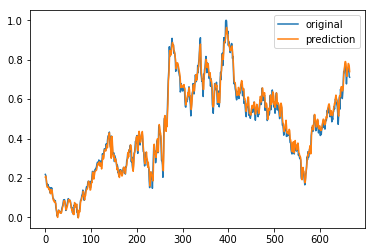

In [39]:
plt.plot(testY)
plt.plot(model(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()

### 3. RNN 모델 평가하기

In [32]:
y_true = testY
y_pred = model(testX_tensor).data.numpy()

In [33]:
mean_absolute_error(model(testX_tensor).data.numpy(), testY)

0.03135489122180099